In [1]:
import numpy as np
import sklearn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import math
import pylab 
from sklearn.linear_model import  LassoLarsIC
import statsmodels.api as sm
import scipy

# Functions

In [2]:
def cum_sum(array, years):
    rcParams['figure.figsize'] = 15, 8
    # Рассчет накопленных сумм
    cumsum_array = np.cumsum(array)
    
    # Рассчитываем среднюю разницу между соседними элементами массива
    diffs = []
    for i in range(0, len(cumsum_array)):
        if i == 0:
            pass
        else:
            last = cumsum_array[i-1]
            current = cumsum_array[i]
            diff = current - last
            diffs.append(diff)
    diffs = np.array(diffs)
    
    # Медианное значение разницы между соседними элементами
    median_diff = np.median(diffs)
    
    # Поиск наиболее заметного перелома:
    fractures = []
    for i in range(0, len(cumsum_array)):
        if i == 0:
            fractures.append(0)
        elif i == 1:
            fractures.append(0)
        else:
            # Используются данные текущего наблюдения + за два предыдущих наблюдения
            pre_last = cumsum_array[i-2]
            last = cumsum_array[i-1]
            current = cumsum_array[i]
            # Действующая разница 
            curr_diff = current - last
            # Разница, которая была на предыдущем шаге
            last_diff = last - pre_last
            # Среднее значение
            main_diff = (curr_diff + last_diff)/2
            
            # Насколько действующая разница больше или меньше среднего значения разности
            value = abs(main_diff - median_diff)
            fractures.append(value)
    fractures = np.array(fractures)
    
    # Условимся считать, что первые 15 и последние 15 элементов в ряду 
    # нам не слудет рассматривать при поиске излома
    new_fractures = fractures[15:-15]
        
    # Допустимый уровень расхожения - 40 процентов
    threshold = ((max(array) - min(array))/100)*40
    # Если хотя бы одно значение из массива больше порогового, то мы имеем дело с изломом
    if any(threshold < fracture for fracture in new_fractures):
        # Индекс "переломного момента"
        id_fracture = np.argwhere(fractures == max(new_fractures))[0][0]
        year_fracture = int(years[id_fracture])
        
        # Линейная регрессия для первой части ряда
        LR1 = LinearRegression()
        years_1 = np.array(years[:id_fracture]).reshape((-1,1))
        cumsum_1 =  np.array(cumsum_array[:id_fracture]).reshape((-1,1))
        LR1.fit(years_1, cumsum_1)
        
        # Линейная регрессия для второй части ряда
        LR2 = LinearRegression()
        years_2 = np.array(years[id_fracture:]).reshape((-1,1))
        cumsum_2 =  np.array(cumsum_array[id_fracture:]).reshape((-1,1))
        LR2.fit(years_2, cumsum_2)
        
        
        # Зададим две точки, по которым будем рисовать прямую
        l1 = np.array([[min(years)], [max(years)]])
        l2 = np.array([[1969], [max(years)]])

        plt.plot(years, cumsum_array, '-ok', c = 'blue', alpha = 0.7, label = 'Cumulative sum')
        plt.plot(l1, LR1.predict(l1), c = 'red', alpha = 0.5, label = 'The first part with extrapolation', linewidth = 3)
        plt.plot(l2, LR2.predict(l2), c = 'orange', alpha = 0.5, label = 'The second part with the extrapolation', linewidth = 3)
        plt.scatter(years[id_fracture], cumsum_array[id_fracture], c = 'yellow', s = 400, alpha = 0.8, label = 'The expected point of fracture')
        plt.xlabel('Year', fontsize = 15)
        plt.ylabel('Cumulative sum', fontsize = 15)
        plt.legend(fontsize = 12)
        plt.grid()
        plt.show()

        print('Estimated fracture year -', year_fracture)
        print('Index of the expected fracture -', id_fracture)
    else:
        print('No fractures were found')
        
# Расчет метрики - cредняя абсолютная процентная ошибка
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)
    # У представленной ниже формулы есть недостаток, - если в массиве y_true есть хотя бы одно значение 0.0,
    # то по формуле np.mean(np.abs((y_true - y_pred) / y_true)) * 100 мы получаем inf, поэтому
    zero_indexes = np.argwhere(y_true == 0.0)
    for index in zero_indexes:
        y_true[index] = 0.01
    value = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return(value)

# Зададим функцию, которая будет выводить на экран значения метрик
def print_metrics(y_test, prediction, model, r2 = False):
    print('Mean absolute error in the test sample -', mean_absolute_error(y_test, prediction))
    print('Median absolute error in the test sample -', median_absolute_error(y_test, prediction))
    print('Root mean square error in the test sample -', mean_squared_error(y_test, prediction)**0.5)
    print('Mean absolute percentage error in the test sample -',mean_absolute_percentage_error(y_test, prediction))
    if r2 == True:
        print('Coefficient of determination in the training sample -', r2_score(y_train, model.predict(X_train)))

# Зададим функцию для отрисовки графиков
def residuals_plots(y_test, prediction, color = 'blue'):
    prediction = np.ravel(prediction)
    y_test = np.ravel(y_test)
    # Рассчитываем ошибки
    errors = prediction - y_test
    errors = np.ravel(errors)
    
    plot_data = pd.DataFrame({'Errors': errors,
                              'Prediction': prediction})
    
    with sns.axes_style("ticks"):
        g = (sns.jointplot('Prediction', 'Errors',  height = 7, alpha = 0.6,
                           data=plot_data, color= color).plot_joint(sns.kdeplot, zorder=0, n_levels=6))
        g.ax_joint.plot([min(prediction)-0.1, max(prediction)+0.1],[0, 0], linewidth = 1, linestyle='--', color= color)
        g.ax_marg_y.axhline(y = 0, linewidth = 1, linestyle='--', color= color)
        plt.xlabel('Predicted value', fontsize = 15)
        plt.ylabel('Errors, tones/ha', fontsize = 15)
        plt.show()
        
        g = (sns.jointplot('Prediction', 'Errors', kind="kde", data = plot_data, space=0, height = 7,
                      color = color, alpha = 0.2))
        g.set_axis_labels('Predicted value', 'Errors, tones/ha', fontsize = 15)
        g.ax_joint.plot([min(prediction)-0.1, max(prediction)+0.1],[0, 0], linewidth = 1, linestyle='--', color= color)
        g.ax_marg_y.axhline(y = 0, linewidth = 1, linestyle='--', color= color)
        plt.show()

# **Netherlands model as Predictor for futures**

Cumulative sum method. Results: 

*   Median absolute error in the test sample - 1.1418
*   MAE in the test sample - 1.126
*   Root mean square error in the test sample - 1.304
*   Coefficient of determination in the training sample - 0.466











In [3]:
#Data loading
data = pd.read_csv('D:/Private/Study/Mutivariable analysis project/crop_data/Netherlands.csv', sep = ',')
data.dropna(axis=1, inplace=True)
#data.set_index('Year', inplace=True)
data.drop(['Entity','Greece_pressure'], inplace=True, axis=1)
data.head()

Precip_amount  Precip_days  Pressure_mean  Sweden_pressure  \
0      360.08380         76.0      991.86554       1002.46170   
1      304.16254         74.0      991.54156       1003.04160   
2      264.90000         57.0      991.18960       1009.54596   
3      247.98102         56.0      993.79254       1008.34420   
4      386.29830         79.0      990.51843       1004.89140   

   Ireland_pressure  Portugal_pressure  Temperature_max  Temperature_min  \
0          995.2163         1013.98834        24.407875       -10.783240   
1          997.2544         1012.53150        24.734243        -9.040615   
2          993.7461         1009.40594        24.166985       -18.094860   
3          996.3119         1011.71810        28.972569       -10.798939   
4          996.1179         1012.11725        23.572124       -10.302626   

   Temperature_SAT  Year  Wheat (tonnes per hectare)  \
0        972.71570  1961                      3.9251   
1        615.37680  1962                      4.5475   
2        808.23517  1963                      4.1962   
3        989.77814  1964                      4.7064   
4        756.73474  1965                      4.4429   

   Maize (tonnes per hectare)  Potatoes (tonnes per hectare)  \
0                      3.8984                        28.0396   
1                      3.8052                        30.4970   
2                      4.2619                        28.7836   
3                      4.0000                        32.9901   
4                      4.1667                        25.8898   

   Beans (tonnes per hectare)  Peas (tonnes per hectare)  \
0                      2.0369                     3.5884   
1                      2.3616                     4.2827   
2                      2.2453                     3.6422   
3                      2.5452                     3.5393   
4                      1.9332                     2.7712   

   Barley (tonnes per hectare)  Total population (Gapminder)  \
0                       3.7541                    11606000.0   
1                       4.2987                    11767000.0   
2                       3.8264                    11928000.0   
3                       4.3150                    12089000.0   
4                       3.7810                    12248000.0   

   Land used for cereal (hectares)  Cereal production (tonnes)  \
0                         521762.0                   1926025.0   
1                         509284.0                   2178426.0   
2                         488375.0                   1947084.0   
3                         481317.0                   2115764.0   
4                         484309.0                   1779071.0   

   Cereal yield (tonnes per hectare)  
0                             3.6914  
1                             4.2774  
2                             3.9869  
3                             4.3958  
4                             3.6734

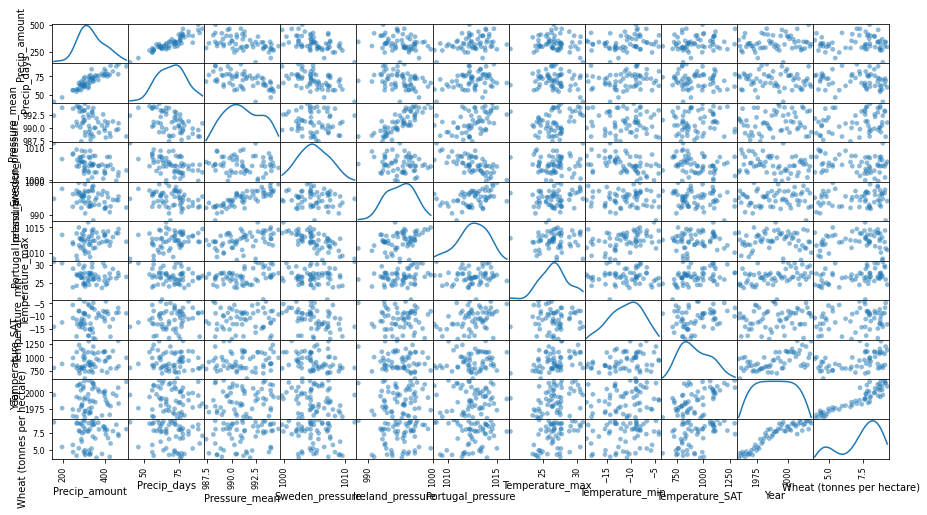

<Figure size 1584x1296 with 0 Axes>

In [345]:
#rcParams['figure.figsize'] = 22, 18
pd.plotting.scatter_matrix(data.loc[:, "Precip_amount":"Wheat (tonnes per hectare)"], 
                           diagonal="kde", s = 90)
plt.figure(figsize=(22,18))
plt.show()

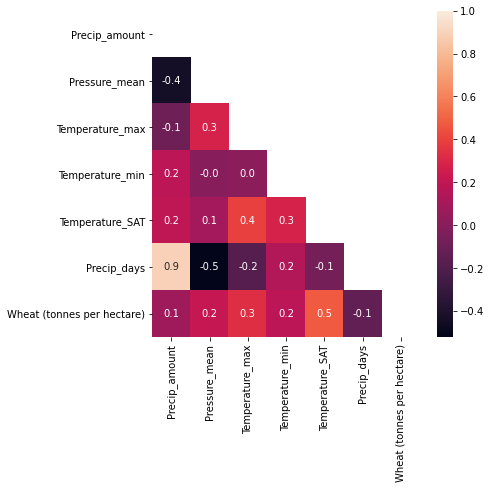

In [346]:
dataset = data[['Precip_amount', 'Pressure_mean','Temperature_max','Temperature_min','Temperature_SAT','Precip_days','Wheat (tonnes per hectare)']]
corr = dataset.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(6, 6))

sns.heatmap(corr, mask=mask, annot=True, fmt= '.1f', ax = ax)

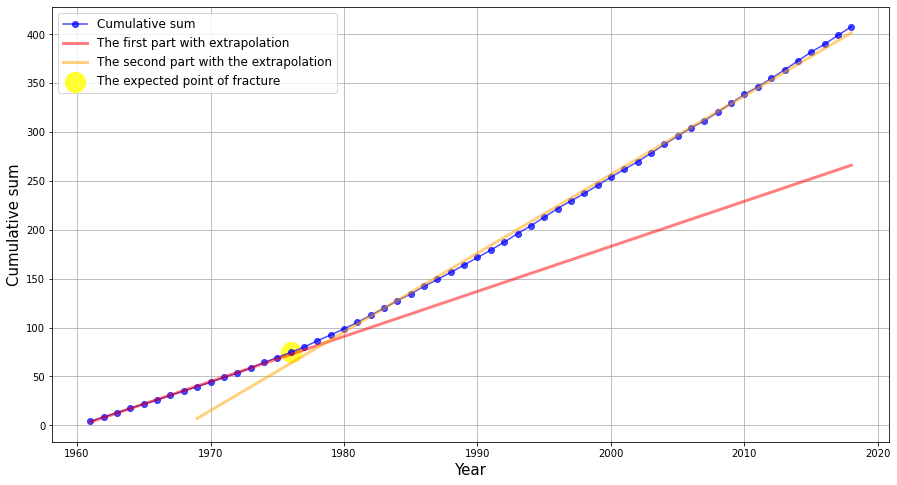

Estimated fracture year - 1976
Index of the expected fracture - 15


In [347]:
cum_sum(data['Wheat (tonnes per hectare)'], data['Year'])

In [348]:
arr = data['Wheat (tonnes per hectare)']
# Разделяем выборки по индексу излома
ar1 = arr[:15]
ar2 = arr[15:]

scipy.stats.ks_2samp(ar1, ar2)

Ks_2sampResult(statistic=0.9534883720930233, pvalue=9.142464563183239e-12)

In [349]:
scipy.stats.kruskal(ar1, ar2)

KruskalResult(statistic=32.18927867560109, pvalue=1.3986040009634242e-08)

In [350]:
data.set_index('Year', inplace=True)

In [351]:
data_train = data.loc[1976:1993]
data_test = data.loc[1994:2018]

# Предикторы
scaler = StandardScaler()
X_train = scaler.fit_transform(data_train[['Precip_amount' , 'Temperature_SAT', 'Precip_days', 'Pressure_mean', 'Temperature_min']])
X_test = scaler.transform(data_test[['Precip_amount' , 'Temperature_SAT', 'Precip_days', 'Pressure_mean', 'Temperature_min']])
                          
y_train = data_train['Wheat (tonnes per hectare)']
y_test = data_test['Wheat (tonnes per hectare)']
                          
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [352]:
LR = LinearRegression()
LR.fit(X_train, y_train)
predicted_Netherlands = LR.predict(X_test)

In [353]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score


Mean absolute error in the test sample - 1.1126942508497555
Median absolute error in the test sample - 1.0776349437976958
Root mean square error in the test sample - 1.2801568119511302
Mean absolute percentage error in the test sample - 12.877607630390173
Coefficient of determination in the training sample - 0.46098180680444756


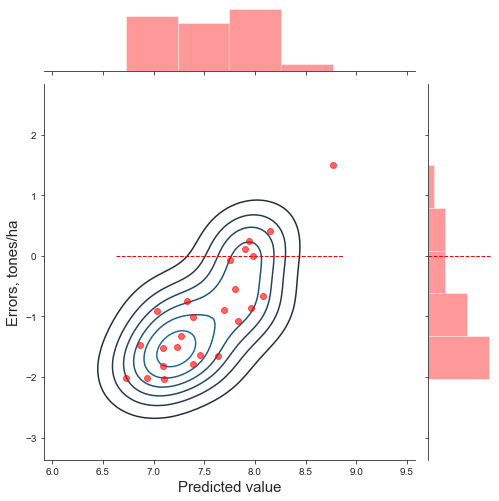

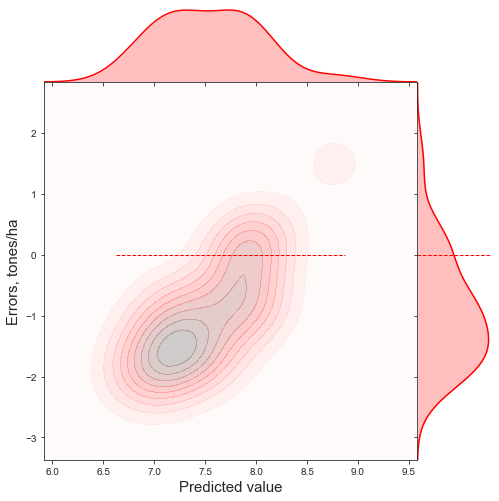

In [354]:
rcParams['figure.figsize'] = 15, 8
print_metrics(y_test, predicted_Netherlands, LR, r2 = True)
residuals_plots(y_test, predicted_Netherlands, color = 'red')

# **Germany model as Predictor for futures**

Cumulative sum method for Germany. Results: 

*   Median absolute error in the test sample - 0.7137
*   MAE in the test sample - 0.6986
*   Root mean square error in the test sample - 0.8721
*   Coefficient of determination in the training sample - 0.070
*   Mean absolute percentage error in the test sample - 9.745




In [355]:
#Data loading
data = pd.read_csv('D:\Private\Study\Mutivariable analysis project\crop_data\old\Germany.csv', sep = ',')
data.dropna(axis=1, inplace=True)
#data.set_index('Year', inplace=True)
data.drop('Entity', inplace=True, axis=1)
data.head()

Precip_amount  Precip_days  Pressure_mean  Temperature_max  \
0      432.19067         80.0     1012.66360        28.702463   
1      351.39365         76.0     1011.81710        28.033005   
2      263.04584         58.0     1011.87775        27.322067   
3      269.39750         58.0     1014.76843        30.800814   
4      469.53720         87.0     1010.86523        26.968662   

   Temperature_min  Temperature_SAT  Year  Wheat (tonnes per hectare)  \
0       -14.800680        914.26886  1961                      2.8607   
1       -12.868017        669.32270  1962                      3.3898   
2       -21.736889        870.11070  1963                      3.3934   
3       -14.934992       1006.01170  1964                      3.4845   
4       -14.866151        725.70233  1965                      3.2321   

   Maize (tonnes per hectare)  Potatoes (tonnes per hectare)  \
0                      2.8979                        18.0590   
1                      3.2319                        22.5080   
2                      3.4526                        23.1439   
3                      3.3691                        20.9811   
4                      3.5354                        20.5188   

   Peas (tonnes per hectare)  Barley (tonnes per hectare)  
0                     1.3891                       2.3640  
1                     1.5287                       3.2451  
2                     1.1979                       3.0346  
3                     1.3946                       3.3476  
4                     1.7530                       2.9678

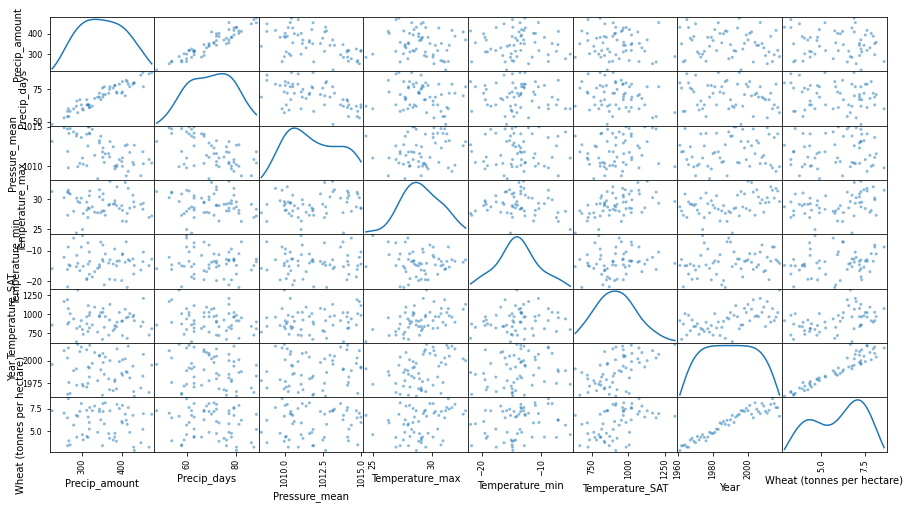

In [356]:
pd.plotting.scatter_matrix(data.loc[:, "Precip_amount":"Wheat (tonnes per hectare)"], diagonal="kde")
plt.show()

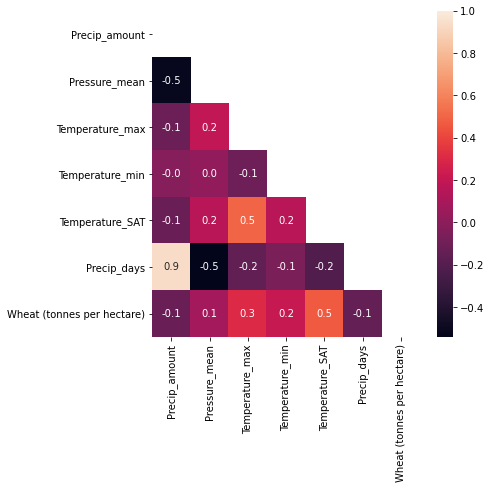

In [357]:
dataset = data[['Precip_amount', 'Pressure_mean','Temperature_max','Temperature_min','Temperature_SAT','Precip_days','Wheat (tonnes per hectare)']]
corr = dataset.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(6, 6))

sns.heatmap(corr, mask=mask, annot=True, fmt= '.1f', ax = ax)

In [358]:
def cum_sum(array, years):  
    # Рассчет накопленных сумм
    cumsum_array = np.cumsum(array)
    
    # Рассчитываем среднюю разницу между соседними элементами массива
    diffs = []
    for i in range(0, len(cumsum_array)):
        if i == 0:
            pass
        else:
            last = cumsum_array[i-1]
            current = cumsum_array[i]
            diff = current - last
            diffs.append(diff)
    diffs = np.array(diffs)
    
    # Медианное значение разницы между соседними элементами
    median_diff = np.median(diffs)
    
    # Поиск наиболее заметного перелома:
    fractures = []
    for i in range(0, len(cumsum_array)):
        if i == 0:
            fractures.append(0)
        elif i == 1:
            fractures.append(0)
        else:
            # Используются данные текущего наблюдения + за два предыдущих наблюдения
            pre_last = cumsum_array[i-2]
            last = cumsum_array[i-1]
            current = cumsum_array[i]
            # Действующая разница 
            curr_diff = current - last
            # Разница, которая была на предыдущем шаге
            last_diff = last - pre_last
            # Среднее значение
            main_diff = (curr_diff + last_diff)/2
            
            # Насколько действующая разница больше или меньше среднего значения разности
            value = abs(main_diff - median_diff)
            fractures.append(value)
    fractures = np.array(fractures)
    
    # Условимся считать, что первые 15 и последние 15 элементов в ряду 
    # нам не слудет рассматривать при поиске излома
    new_fractures = fractures[15:-15]
        
    # Допустимый уровень расхожения - 40 процентов
    threshold = ((max(array) - min(array))/100)*40
    # Если хотя бы одно значение из массива больше порогового, то мы имеем дело с изломом
    if any(threshold < fracture for fracture in new_fractures):
        # Индекс "переломного момента"
        id_fracture = np.argwhere(fractures == max(new_fractures))[0][0]
        year_fracture = int(years[id_fracture])
        
        # Линейная регрессия для первой части ряда
        LR1 = LinearRegression()
        years_1 = np.array(years[:id_fracture]).reshape((-1,1))
        cumsum_1 =  np.array(cumsum_array[:id_fracture]).reshape((-1,1))
        LR1.fit(years_1, cumsum_1)
        
        # Линейная регрессия для второй части ряда
        LR2 = LinearRegression()
        years_2 = np.array(years[id_fracture:]).reshape((-1,1))
        cumsum_2 =  np.array(cumsum_array[id_fracture:]).reshape((-1,1))
        LR2.fit(years_2, cumsum_2)
        
        
        # Зададим две точки, по которым будем рисовать прямую
        l1 = np.array([[min(years)], [max(years)]])
        l2 = np.array([[1969], [max(years)]])

        plt.plot(years, cumsum_array, '-ok', c = 'blue', alpha = 0.7, label = 'Cumulative sum')
        plt.plot(l1, LR1.predict(l1), c = 'red', alpha = 0.5, label = 'The first part with extrapolation', linewidth = 3)
        plt.plot(l2, LR2.predict(l2), c = 'orange', alpha = 0.5, label = 'The second part with the extrapolation', linewidth = 3)
        plt.scatter(years[id_fracture], cumsum_array[id_fracture], c = 'yellow', s = 400, alpha = 0.8, label = 'The expected point of fracture')
        plt.xlabel('Year', fontsize = 15)
        plt.ylabel('Cumulative sum', fontsize = 15)
        plt.legend(fontsize = 12)
        plt.grid()
        plt.show()

        print('Estimated fracture year -', year_fracture)
        print('Index of the expected fracture -', id_fracture)
    else:
        print('No fractures were found')
    


In [359]:
cum_sum(data['Wheat (tonnes per hectare)'], data['Year'])

No fractures were found


In [360]:
data.set_index('Year', inplace=True)

In [361]:
data_train = data.loc[1961:1993]
data_test = data.loc[1994:2018]

# Предикторы
scaler = StandardScaler()
X_train = scaler.fit_transform(data_train[['Precip_amount' , 'Temperature_SAT', 'Precip_days', 'Pressure_mean', 'Temperature_min']])
X_test = scaler.transform(data_test[['Precip_amount' , 'Temperature_SAT', 'Precip_days', 'Pressure_mean', 'Temperature_min']])
                          
y_train = data_train['Wheat (tonnes per hectare)']
y_test = data_test['Wheat (tonnes per hectare)']
                          
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [362]:
LR = LinearRegression()
LR.fit(X_train, y_train)
predicted_Germany = LR.predict(X_test)

Mean absolute error in the test sample - 2.551973834213908
Median absolute error in the test sample - 2.4905062485071587
Root mean square error in the test sample - 2.6171036104610703
Mean absolute percentage error in the test sample - 34.05021367055328
Coefficient of determination in the training sample - 0.07004886330776972


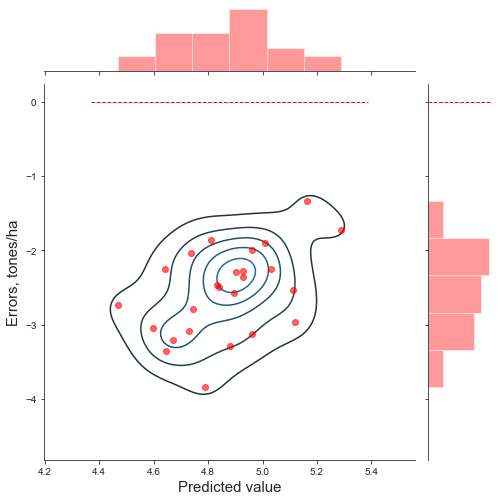

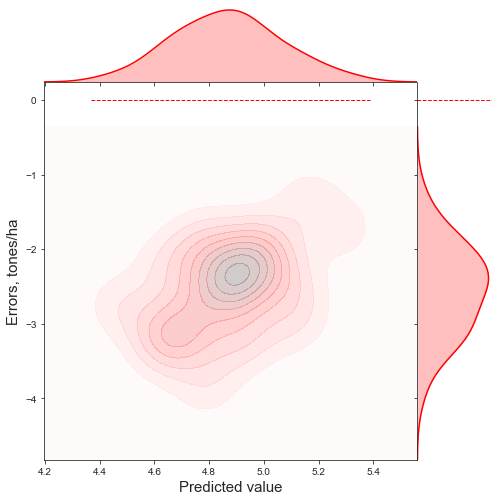

In [363]:
rcParams['figure.figsize'] = 15, 8
print_metrics(y_test, predicted_Germany, LR, r2 = True)
residuals_plots(y_test, predicted_Germany, color = 'red')

# **France model as Predictor for futures**

Cumulative sum method for France. Results: 

*   Median absolute error in the test sample - 0.4389
*   MAE in the test sample - 0.7177
*   Root mean square error in the test sample - 1.0204
*   Coefficient of determination in the training sample - 0.5660
*   Mean absolute percentage error in the test sample - 11.0776


In [365]:
#Data loading
data = pd.read_csv('D:\Private\Study\Mutivariable analysis project\crop_data\old\France.csv', sep = ',')
data.dropna(axis=1, inplace=True)
#data.set_index('Year', inplace=True)
data.drop('Entity', inplace=True, axis=1)
data.head()

Precip_amount  Precip_days  Pressure_mean  Temperature_max  \
0      335.32913         58.0     1007.24774        29.325258   
1      356.82460         60.0     1006.49133        28.203970   
2      396.65167         67.0     1003.21857        27.865587   
3      336.72687         56.0     1006.48865        29.326975   
4      364.31058         67.0     1013.66675        28.627384   

   Temperature_min  Temperature_SAT  Year  Wheat (tonnes per hectare)  \
0        -5.150779        1261.3372  1961                      2.3950   
1        -8.424414         894.5200  1962                      3.0752   
2       -15.265487         995.3440  1963                      2.6624   
3        -8.304780        1180.9784  1964                      3.1534   
4        -8.730706        1031.2886  1965                      3.2655   

   Rice (tonnes per hectare)  Maize (tonnes per hectare)  \
0                     4.0512                      2.5291   
1                     4.1875                      2.1489   
2                     3.9753                      4.0593   
3                     4.0610                      2.3546   
4                     3.2935                      3.9800   

   Potatoes (tonnes per hectare)  Beans (tonnes per hectare)  \
0                        16.0992                      0.9076   
1                        15.5289                      0.8428   
2                        18.9265                      1.0840   
3                        16.7369                      0.9134   
4                        19.5147                      1.0500   

   Peas (tonnes per hectare)  Barley (tonnes per hectare)  
0                     1.9000                       2.3960  
1                     2.4239                       2.7581  
2                     2.2292                       2.9088  
3                     2.2645                       2.8774  
4                     2.1996                       3.0363

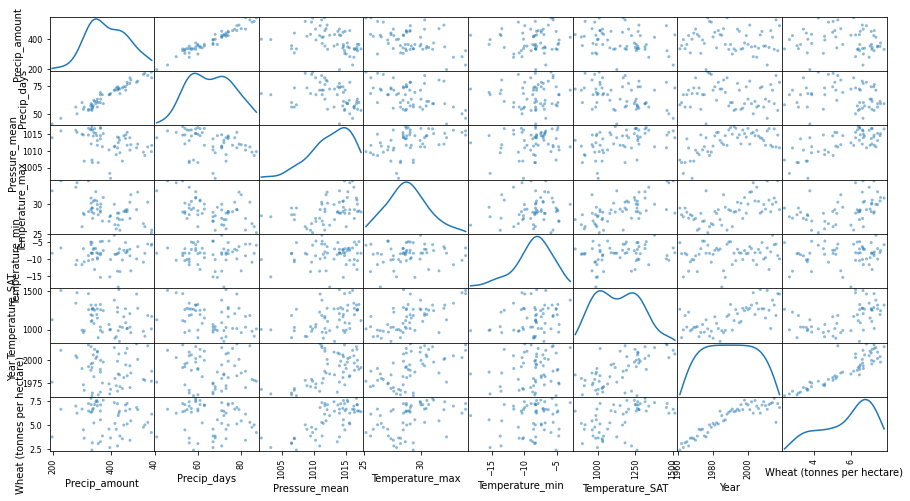

In [366]:
pd.plotting.scatter_matrix(data.loc[:, "Precip_amount":"Wheat (tonnes per hectare)"], diagonal="kde")
plt.show()

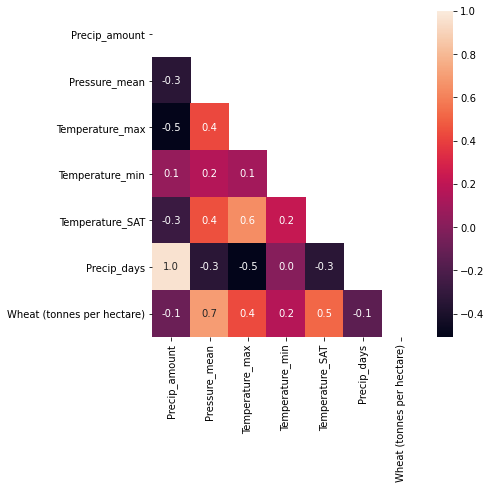

In [367]:
dataset = data[['Precip_amount', 'Pressure_mean','Temperature_max','Temperature_min','Temperature_SAT','Precip_days','Wheat (tonnes per hectare)']]
corr = dataset.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(6, 6))

sns.heatmap(corr, mask=mask, annot=True, fmt= '.1f', ax = ax)

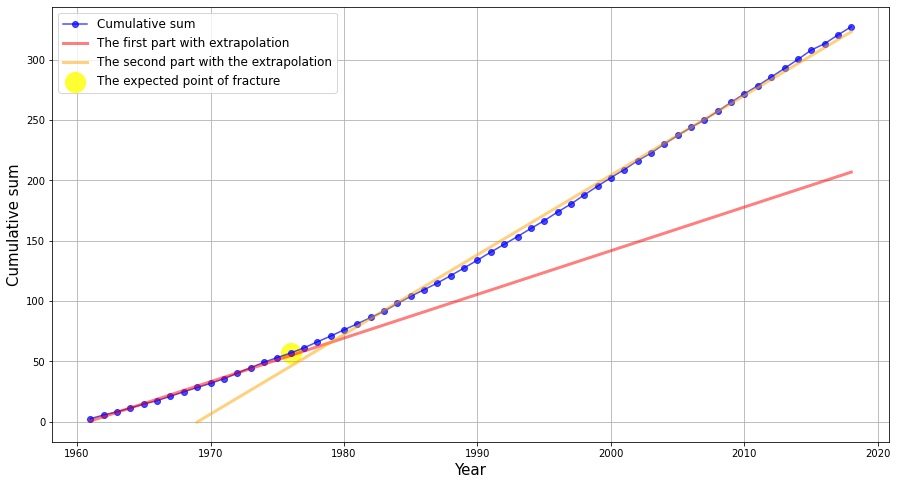

Estimated fracture year - 1976
Index of the expected fracture - 15


In [368]:
cum_sum(data['Wheat (tonnes per hectare)'], data['Year'])

In [369]:
arr = data['Wheat (tonnes per hectare)']
# Разделяем выборки по индексу излома
ar1 = arr[:15]
ar2 = arr[15:]

scipy.stats.ks_2samp(ar1, ar2)

Ks_2sampResult(statistic=0.9534883720930233, pvalue=9.142464563183239e-12)

In [370]:
scipy.stats.kruskal(ar1, ar2)

KruskalResult(statistic=31.189672841939313, pvalue=2.3400766441504337e-08)

In [371]:
data.set_index('Year', inplace=True)

In [372]:
data_train = data.loc[1975:1993]
data_test = data.loc[1994:2018]

# Предикторы
scaler = StandardScaler()
X_train = scaler.fit_transform(data_train[['Precip_amount' , 'Temperature_SAT', 'Precip_days', 'Pressure_mean', 'Temperature_min']])
X_test = scaler.transform(data_test[['Precip_amount' , 'Temperature_SAT', 'Precip_days', 'Pressure_mean', 'Temperature_min']])
                          
y_train = data_train['Wheat (tonnes per hectare)']
y_test = data_test['Wheat (tonnes per hectare)']
                          
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [373]:
LR = LinearRegression()
LR.fit(X_train, y_train)
predicted_France = LR.predict(X_test)

Mean absolute error in the test sample - 1.7525521247089246
Median absolute error in the test sample - 1.9784332295669014
Root mean square error in the test sample - 1.9202551830560068
Mean absolute percentage error in the test sample - 24.77850185488102
Coefficient of determination in the training sample - 0.566045697913669


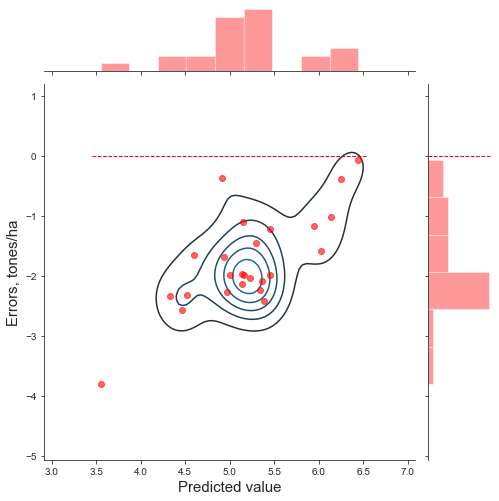

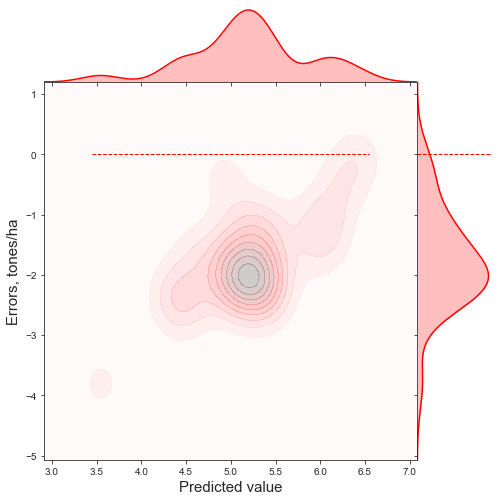

In [374]:
rcParams['figure.figsize'] = 15, 8
print_metrics(y_test, predicted_France, LR, r2 = True)
residuals_plots(y_test, predicted_France, color = 'red')

# **Switzerland model as Predictor for futures**

Cumulative sum method for Switzerland. Results: 

*   Median absolute error in the test sample - 1.5664
*   MAE in the test sample - 1.7226
*   Root mean square error in the test sample - 1.8535
*   Coefficient of determination in the training sample - 0.2397
*   Mean absolute percentage error in the test sample - 30.6146

In [375]:
#Data loading
data = pd.read_csv('D:\Private\Study\Mutivariable analysis project\crop_data\old\Switzerland.csv', sep = ',')
data.dropna(axis=1, inplace=True)
#data.set_index('Year', inplace=True)
data.drop('Entity', inplace=True, axis=1)
data.head()

Precip_amount  Precip_days  Pressure_mean  Temperature_max  \
0      560.29565         77.0      1018.3402        24.226086   
1      589.27040         72.0      1016.9646        25.094843   
2      561.04803         75.0      1014.5954        24.939772   
3      489.68115         67.0      1018.1109        24.184100   
4      708.00397         92.0      1016.0630        26.288778   

   Temperature_min  Temperature_SAT  Year  Wheat (tonnes per hectare)  \
0       -10.245839        552.97640  1961                      2.7134   
1       -16.272070        441.67972  1962                      3.8648   
2       -22.656458        473.19098  1963                      2.8725   
3       -11.931800        631.87775  1964                      3.6435   
4       -16.713560        449.56580  1965                      3.2267   

   Maize (tonnes per hectare)  Potatoes (tonnes per hectare)  \
0                      4.6734                        24.3000   
1                      4.5246                        23.0000   
2                      4.8967                        26.5000   
3                      4.9201                        26.8000   
4                      4.2241                        23.1003   

   Barley (tonnes per hectare)  
0                       3.1457  
1                       3.5348  
2                       2.9664  
3                       3.5043  
4                       3.0817

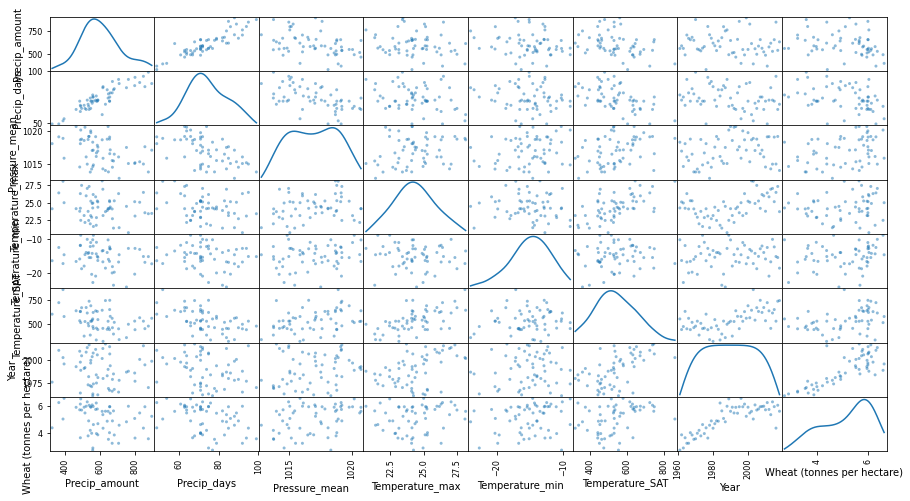

In [376]:
pd.plotting.scatter_matrix(data.loc[:, "Precip_amount":"Wheat (tonnes per hectare)"], diagonal="kde")
plt.show()

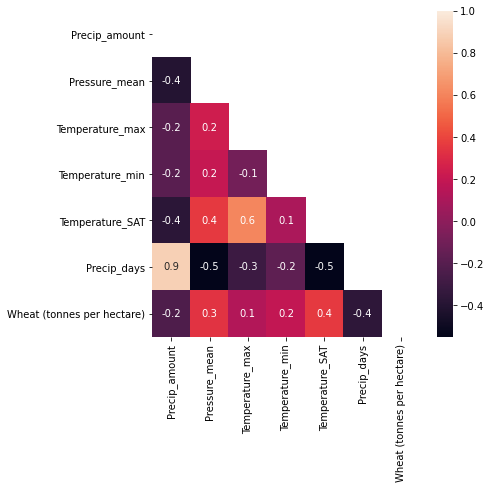

In [377]:
dataset = data[['Precip_amount', 'Pressure_mean','Temperature_max','Temperature_min','Temperature_SAT','Precip_days','Wheat (tonnes per hectare)']]
corr = dataset.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(6, 6))

sns.heatmap(corr, mask=mask, annot=True, fmt= '.1f', ax = ax)

In [378]:
cum_sum(data['Wheat (tonnes per hectare)'], data['Year'])

No fractures were found


In [379]:
data.set_index('Year', inplace=True)

In [380]:
data_train = data.loc[1961:1993]
data_test = data.loc[1994:2018]

# Предикторы
scaler = StandardScaler()
X_train = scaler.fit_transform(data_train[['Precip_amount' , 'Temperature_SAT', 'Precip_days', 'Pressure_mean', 'Temperature_min']])
X_test = scaler.transform(data_test[['Precip_amount' , 'Temperature_SAT', 'Precip_days', 'Pressure_mean', 'Temperature_min']])
                          
y_train = data_train['Wheat (tonnes per hectare)']
y_test = data_test['Wheat (tonnes per hectare)']
                          
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [381]:
LR = LinearRegression()
LR.fit(X_train, y_train)
predicted_Switzerland = LR.predict(X_test)

Mean absolute error in the test sample - 1.7389581693699894
Median absolute error in the test sample - 1.6900927370329946
Root mean square error in the test sample - 1.8443187192450161
Mean absolute percentage error in the test sample - 29.619980406423434
Coefficient of determination in the training sample - 0.2397363891653691


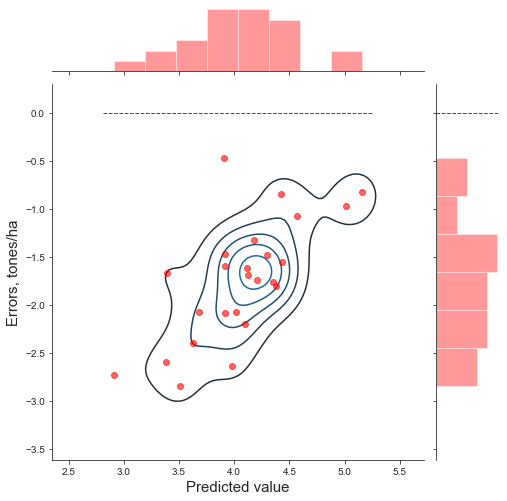

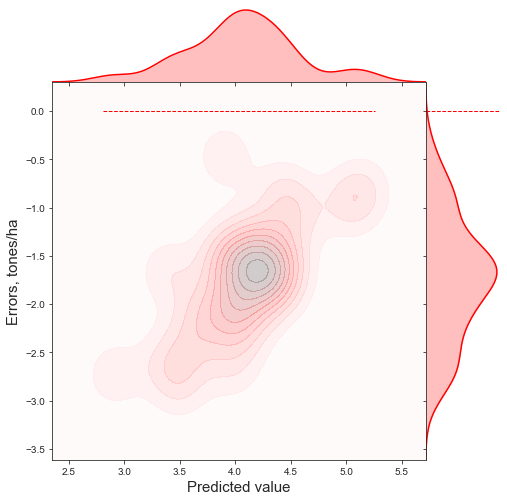

In [382]:
rcParams['figure.figsize'] = 15, 8
print_metrics(y_test, predicted_Switzerland, LR, r2 = True)
residuals_plots(y_test, predicted_Switzerland, color = 'red')

# **Austria model as Predictor for futures**

Cumulative sum method for Austria. Results: 

*   Median absolute error in the test sample - 1.5664
*   MAE in the test sample - 1.7226
*   Root mean square error in the test sample - 1.8535
*   Coefficient of determination in the training sample - 0.2397
*   Mean absolute percentage error in the test sample - 30.6146

In [383]:
#Data loading
data = pd.read_csv('D:\Private\Study\Mutivariable analysis project\crop_data\old\Austria.csv', sep = ',')
data.dropna(axis=1, inplace=True)
#data.set_index('Year', inplace=True)
data.drop('Entity', inplace=True, axis=1)
data.head()

Precip_amount  Precip_days  Pressure_mean  Temperature_max  \
0      445.26257         66.0     1018.70150        26.945124   
1      541.44190         70.0     1017.28485        27.850657   
2      411.57580         69.0     1016.01730        28.614426   
3      413.10956         62.0     1019.39996        26.279550   
4      667.49130         84.0     1015.63360        28.183971   

   Temperature_min  Temperature_SAT  Year  Wheat (tonnes per hectare)  \
0       -15.498816        758.71310  1961                      2.5802   
1       -15.246249        561.52580  1962                      2.6122   
2       -23.104338        697.48376  1963                      2.5099   
3       -16.920774        781.26390  1964                      2.6524   
4       -17.289890        541.64703  1965                      2.3969   

   Maize (tonnes per hectare)  Potatoes (tonnes per hectare)  \
0                      3.8605                        19.7806   
1                      3.5620                        19.0451   
2                      3.9033                        21.7780   
3                      4.2359                        21.8247   
4                      3.7315                        17.5672   

   Peas (tonnes per hectare)  Barley (tonnes per hectare)  
0                     1.8903                       2.7262  
1                     1.7528                       2.8830  
2                     2.0323                       2.6952  
3                     2.0629                       2.6638  
4                     1.9533                       2.3758

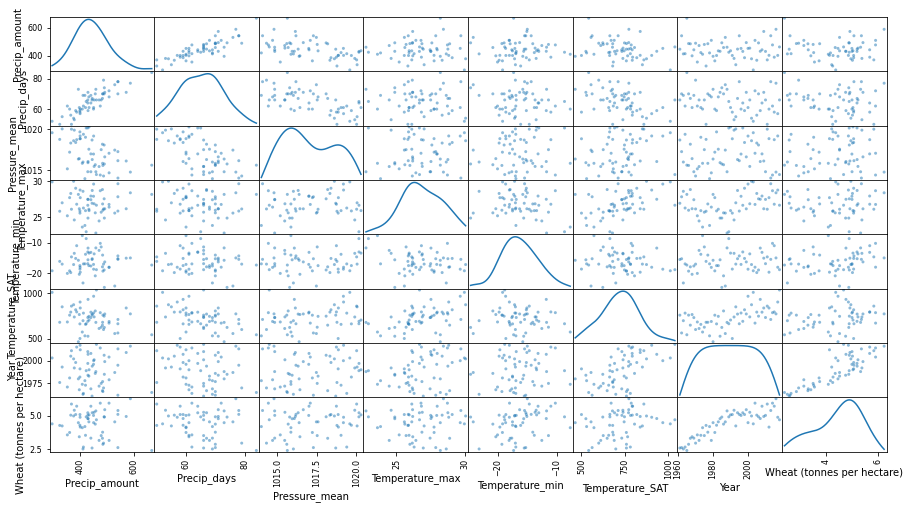

In [384]:
pd.plotting.scatter_matrix(data.loc[:, "Precip_amount":"Wheat (tonnes per hectare)"], diagonal="kde")
plt.show()

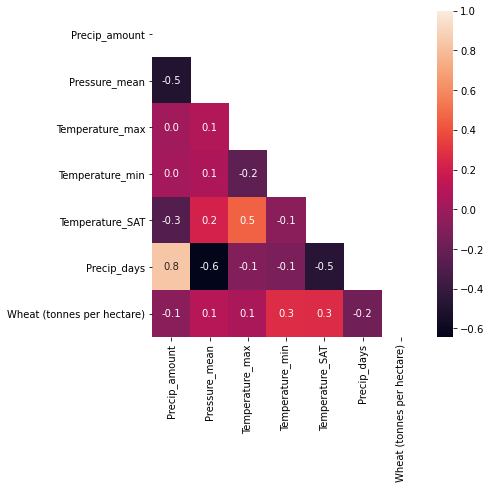

In [385]:
dataset = data[['Precip_amount', 'Pressure_mean','Temperature_max','Temperature_min','Temperature_SAT','Precip_days','Wheat (tonnes per hectare)']]
corr = dataset.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(6, 6))

sns.heatmap(corr, mask=mask, annot=True, fmt= '.1f', ax = ax)

In [386]:
cum_sum(data['Wheat (tonnes per hectare)'], data['Year'])

No fractures were found


In [387]:
data.set_index('Year', inplace=True)

In [388]:
data_train = data.loc[1961:1993]
data_test = data.loc[1994:2018]

# Предикторы
scaler = StandardScaler()
X_train = scaler.fit_transform(data_train[['Precip_amount' , 'Temperature_SAT', 'Precip_days', 'Pressure_mean', 'Temperature_min']])
X_test = scaler.transform(data_test[['Precip_amount' , 'Temperature_SAT', 'Precip_days', 'Pressure_mean', 'Temperature_min']])
                          
y_train = data_train['Wheat (tonnes per hectare)']
y_test = data_test['Wheat (tonnes per hectare)']
                          
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [389]:
LR = LinearRegression()
LR.fit(X_train, y_train)
predicted_Austria = LR.predict(X_test)

Mean absolute error in the test sample - 1.790768170848426
Median absolute error in the test sample - 1.7155353032152738
Root mean square error in the test sample - 1.9318747801223548
Mean absolute percentage error in the test sample - 33.98881126783562
Coefficient of determination in the training sample - 0.2736892637857904


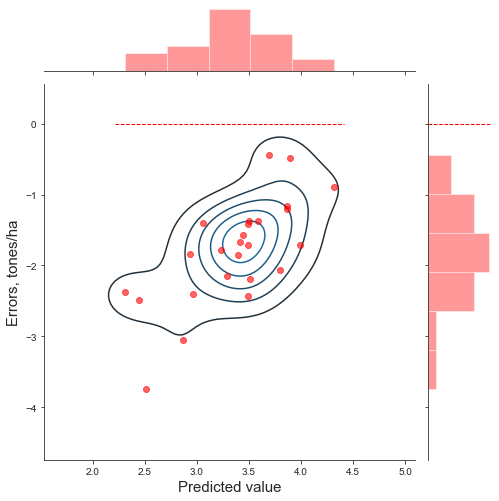

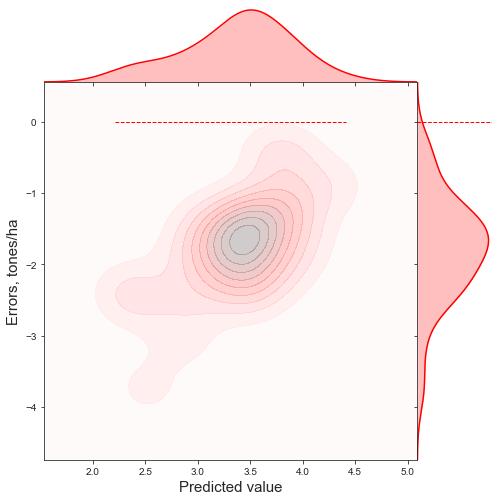

In [390]:
rcParams['figure.figsize'] = 15, 8
print_metrics(y_test, predicted_Austria, LR, r2 = True)
residuals_plots(y_test, predicted_Austria, color = 'red')

# **Poland model as Predictor for futures**

Cumulative sum method for Poland. Results: 

*   Median absolute error in the test sample - 3.5107
*   MAE in the test sample - 3.5826
*   Root mean square error in the test sample - 3.6636
*   Coefficient of determination in the training sample - 0.2304
*   Mean absolute percentage error in the test sample - 94.4559

In [392]:
#Data loading
data = pd.read_csv('D:\Private\Study\Mutivariable analysis project\crop_data\old\Poland.csv', sep = ',')
data.dropna(axis=1, inplace=True)
#data.set_index('Year', inplace=True)
data.drop('Entity', inplace=True, axis=1)
data.head()

Precip_amount  Precip_days  Pressure_mean  Temperature_max  \
0      255.61009         60.0      1014.1542        30.160442   
1      324.49365         70.0      1012.5501        28.714188   
2      183.62457         47.0      1014.7197        31.282389   
3      196.81613         48.0      1017.0867        31.821688   
4      290.09580         68.0      1012.2777        29.891687   

   Temperature_min  Temperature_SAT  Year  Wheat (tonnes per hectare)  \
0       -20.102629        950.85180  1961                      1.9929   
1       -17.164967        764.71950  1962                      1.9383   
2       -27.797865        980.07540  1963                      1.9890   
3       -19.744700        976.02356  1964                      1.8720   
4       -21.655457        648.80634  1965                      2.0639   

   Maize (tonnes per hectare)  Potatoes (tonnes per hectare)  \
0                      2.7731                        16.0340   
1                      2.1591                        12.9951   
2                      2.1212                        15.7986   
3                      2.4324                        16.9141   
4                      2.0290                        15.4293   

   Beans (tonnes per hectare)  Peas (tonnes per hectare)  \
0                      1.2857                     1.0189   
1                      1.1875                     1.1667   
2                      1.1739                     0.9846   
3                      1.1481                     0.9697   
4                      1.3889                     1.3824   

   Barley (tonnes per hectare)  
0                       1.9691  
1                       1.9834  
2                       1.9760  
3                       1.7008  
4                       2.0988

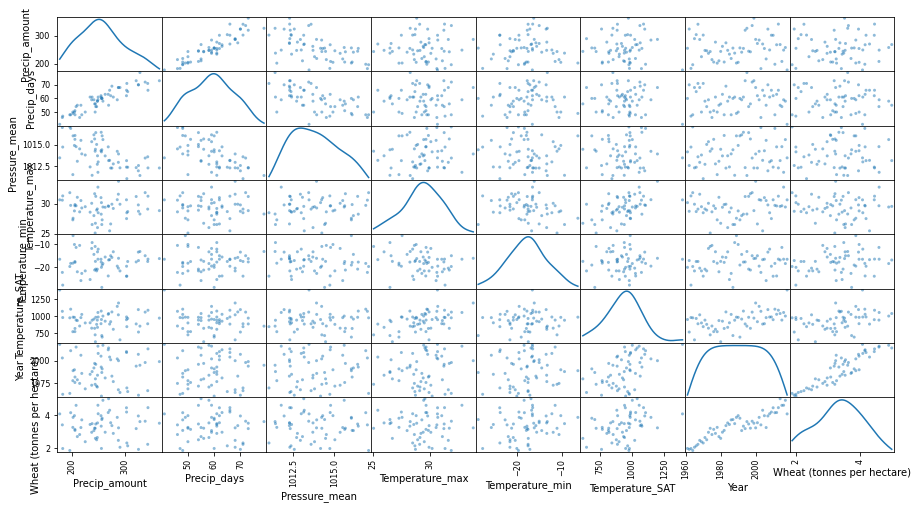

In [393]:
pd.plotting.scatter_matrix(data.loc[:, "Precip_amount":"Wheat (tonnes per hectare)"], diagonal="kde")
plt.show()

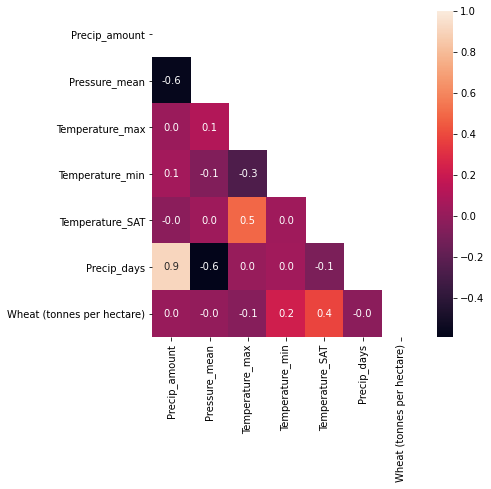

In [394]:
dataset = data[['Precip_amount', 'Pressure_mean','Temperature_max','Temperature_min','Temperature_SAT','Precip_days','Wheat (tonnes per hectare)']]
corr = dataset.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(6, 6))

sns.heatmap(corr, mask=mask, annot=True, fmt= '.1f', ax = ax)

In [395]:
cum_sum(data['Wheat (tonnes per hectare)'], data['Year'])

No fractures were found


In [396]:
data.set_index('Year', inplace=True)

In [397]:
data_train = data.loc[1961:1993]
data_test = data.loc[1994:2018]

# Предикторы
scaler = StandardScaler()
X_train = scaler.fit_transform(data_train[['Precip_amount' , 'Temperature_SAT', 'Pressure_mean', 'Temperature_min']])
X_test = scaler.transform(data_test[['Precip_amount' , 'Temperature_SAT', 'Pressure_mean', 'Temperature_min']])
                          
y_train = data_train['Wheat (tonnes per hectare)']
y_test = data_test['Wheat (tonnes per hectare)']
                          
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [398]:
LR = LinearRegression()
LR.fit(X_train, y_train)
predicted_Poland = LR.predict(X_test)

Mean absolute error in the test sample - 1.1950410504848297
Median absolute error in the test sample - 1.1485195980109264
Root mean square error in the test sample - 1.309555521051819
Mean absolute percentage error in the test sample - 29.30000486725815
Coefficient of determination in the training sample - 0.2303784635582482


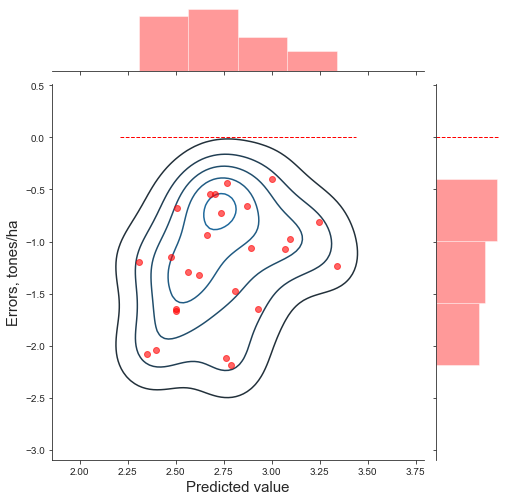

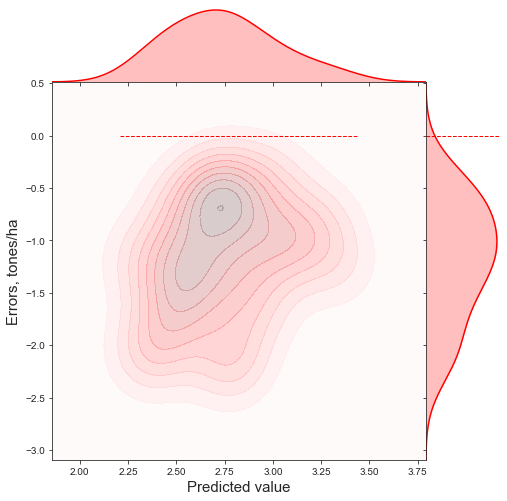

In [399]:
rcParams['figure.figsize'] = 15, 8
print_metrics(y_test, predicted_Poland, LR, r2 = True)
residuals_plots(y_test, predicted_Poland, color = 'red')

# **Italy model as Predictor for futures**

Cumulative sum method for Italy. Results: 

*   Median absolute error in the test sample - 3.9103
*   MAE in the test sample - 3.9764
*   Root mean square error in the test sample - 4.0348
*   Coefficient of determination in the training sample - 0.3244
*   Mean absolute percentage error in the test sample - 115.2073


In [401]:
#Data loading
data = pd.read_csv('D:\Private\Study\Mutivariable analysis project\crop_data\old\Italy.csv', sep = ',')
data.dropna(axis=1, inplace=True)
#data.set_index('Year', inplace=True)
data.drop('Entity', inplace=True, axis=1)
data.head()

Precip_amount  Precip_days  Pressure_mean  Temperature_max  \
0      338.28555         39.0       824.9679        28.800549   
1      360.83597         42.0       823.0858        28.721779   
2      494.80460         58.0       821.6294        28.264019   
3      358.45303         42.0       824.8296        27.886055   
4      375.41660         46.0       818.1153        29.943869   

   Temperature_min  Temperature_SAT  Year  Wheat (tonnes per hectare)  \
0        -5.994743        1510.8029  1961                      1.9103   
1        -8.118163        1281.8699  1962                      2.0847   
2       -11.384465        1299.1104  1963                      1.8494   
3        -7.360264        1446.2456  1964                      1.9477   
4        -7.893300        1253.8232  1965                      2.2796   

   Rice (tonnes per hectare)  Maize (tonnes per hectare)  \
0                     5.6773                      3.2882   
1                     5.5963                      2.9129   
2                     4.9035                      3.2949   
3                     5.2168                      3.6907   
4                     4.0250                      3.2278   

   Soybeans (tonnes per hectare)  Potatoes (tonnes per hectare)  \
0                         1.9167                        10.3832   
1                         1.7824                         9.4531   
2                         1.8214                        11.3594   
3                         1.8333                        10.7440   
4                         1.8077                        10.1908   

   Beans (tonnes per hectare)  Peas (tonnes per hectare)  \
0                      0.5124                     0.6701   
1                      0.4704                     0.8211   
2                      0.6283                     0.8249   
3                      0.6803                     0.8661   
4                      0.5788                     0.8912   

   Barley (tonnes per hectare)  
0                       1.2690  
1                       1.3616  
2                       1.3736  
3                       1.2798  
4                       1.5290

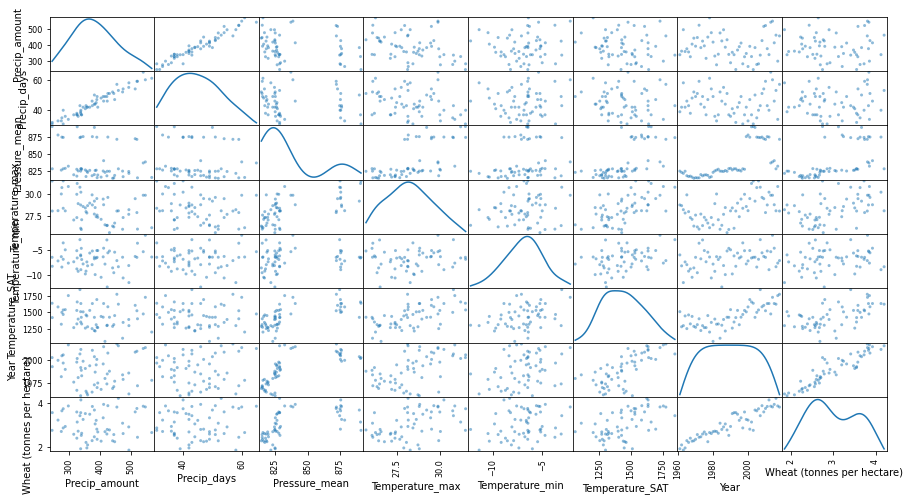

In [402]:
pd.plotting.scatter_matrix(data.loc[:, "Precip_amount":"Wheat (tonnes per hectare)"], diagonal="kde")
plt.show()

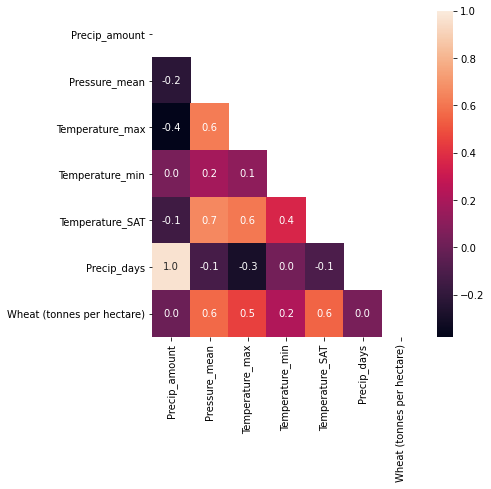

In [403]:
dataset = data[['Precip_amount', 'Pressure_mean','Temperature_max','Temperature_min','Temperature_SAT','Precip_days','Wheat (tonnes per hectare)']]
corr = dataset.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(6, 6))

sns.heatmap(corr, mask=mask, annot=True, fmt= '.1f', ax = ax)

In [404]:
cum_sum(data['Wheat (tonnes per hectare)'], data['Year'])

No fractures were found


In [405]:
data.set_index('Year', inplace=True)

In [406]:
data_train = data.loc[1961:1993]
data_test = data.loc[1994:2018]

# Предикторы
scaler = StandardScaler()
X_train = scaler.fit_transform(data_train[['Precip_amount' , 'Temperature_SAT', 'Pressure_mean', 'Temperature_min']])
X_test = scaler.transform(data_test[['Precip_amount' , 'Temperature_SAT', 'Pressure_mean', 'Temperature_min']])
                          
y_train = data_train['Wheat (tonnes per hectare)']
y_test = data_test['Wheat (tonnes per hectare)']
                          
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [407]:
LR = LinearRegression()
LR.fit(X_train, y_train)
predicted_Italy = LR.predict(X_test)

Mean absolute error in the test sample - 1.218308353590468
Median absolute error in the test sample - 1.0569713552870685
Root mean square error in the test sample - 1.37626119249512
Mean absolute percentage error in the test sample - 35.608277879669465
Coefficient of determination in the training sample - 0.3243652906753681


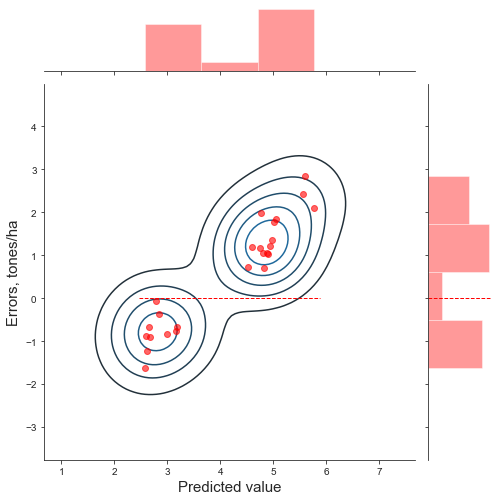

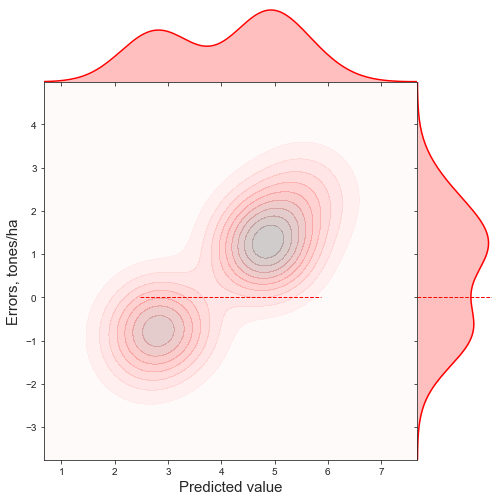

In [408]:
rcParams['figure.figsize'] = 15, 8
print_metrics(y_test, predicted_Italy, LR, r2 = True)
residuals_plots(y_test, predicted_Italy, color = 'red')

# **Futures prediction model**

**Linear regression**
* Mean absolute error in the test sample - 19.1536
* Median absolute error in the test sample - 15.8758
* Root mean square error in the test sample - 24.7212
* Mean absolute percentage error in the test sample - 14.2016
* Coefficient of determination in the training sample - 0.8483

**Random Forest**
* Mean absolute error in the test sample - 25.3083
* Median absolute error in the test sample - 12.1808
* Root mean square error in the test sample - 36.8733
* Mean absolute percentage error in the test sample - 14.3873
* Coefficient of determination in the training sample - 0.9168

**Gradient Boosting**
* Mean absolute error in the test sample - 21.5608
* Median absolute error in the test sample - 7.6546
* Root mean square error in the test sample - 34.7249
* Mean absolute percentage error in the test sample - 12.0026
* Coefficient of determination in the training sample - 0.9168


In [413]:
futures = pd.read_csv('D:/Private/Study/Mutivariable analysis project/futures_data/Feed Wheat 1994-2020.csv', sep = ',')
#data.dropna(axis=1, inplace=True)
#data.set_index('Year', inplace=True)
futures.drop([132,154], inplace=True)
futures.drop(['Contract Name','52W High Date', '52W Low Date'], inplace=True, axis=1)
futures['Time'].replace('.','/', inplace=True)
futures.index = pd.to_datetime(futures['Time'], format='%m/%d/%y')
futures.drop(['52W %Chg','Time'], inplace=True, axis=1)
futures.head()

Exp Date Symbol    Last  52W High  52W Low
Time                                                 
1994-01-21     1994  LWF94   99.00    100.00    98.00
1994-03-22     1994  LWH94  105.50    105.75    96.75
1994-05-23     1994  LWK94  115.75    120.00    97.30
1994-06-22     1994  LWM94  115.00    120.00    97.35
1994-09-23     1994  LWU94  106.25    107.00    89.20

In [418]:
futures = futures.loc[futures.index.month == 11]
futures = futures.loc['1994-11-23':'2018-11-23']
futures.head()

Exp Date Symbol    Last  52W High  52W Low
Time                                                 
1994-11-23     1994  LWX94  104.30     108.0    90.25
1995-11-22     1995  LWX95  127.50     127.6    95.25
1996-11-22     1996  LWX96   95.75     122.5    93.00
1997-11-21     1997  LWX97   80.00     101.5    79.15
1998-11-20     1998  LWX98   77.50      86.5    69.50

In [419]:
futures.index = futures.index.year
futures.drop(["Exp Date", "Symbol"], axis=1, inplace=True)

In [225]:
futures.head()

Last  52W High  52W Low
Time                           
1994  104.30     108.0    90.25
1995  127.50     127.6    95.25
1996   95.75     122.5    93.00
1997   80.00     101.5    79.15
1998   77.50      86.5    69.50

In [215]:
futures.tail()

Last  52W High  52W Low
Time                           
2020  170.25    180.10   145.00
2020  159.45    167.95   152.85
2020  151.70    159.00   145.00
2020  150.00    157.10   147.55
2020  146.10    153.20   144.05

# Previous Prices

In [414]:
last_prices = pd.DataFrame()
last_prices['Prev_price_1'] = np.zeros(len(futures.index.year.unique()[:-2]))
last_prices['Prev_price_2'] = np.zeros(len(futures.index.year.unique()[:-2]))

In [415]:
i=0
for year in futures.index.year.unique()[:-2]:
    last_prices['Prev_price_1'][i] = futures[futures.index.year == year].iloc[-3:]['Last'][0]
    last_prices['Prev_price_2'][i] = futures[futures.index.year == year].iloc[-3:]['Last'][1]
    i+=1
    
    

In [416]:
last_prices.tail()

Prev_price_1  Prev_price_2
20        150.50        132.20
21        111.20        118.50
22        107.00        111.75
23        147.95        147.25
24        152.30        157.00

In [417]:
futures.head()

Exp Date Symbol    Last  52W High  52W Low
Time                                                 
1994-01-21     1994  LWF94   99.00    100.00    98.00
1994-03-22     1994  LWH94  105.50    105.75    96.75
1994-05-23     1994  LWK94  115.75    120.00    97.30
1994-06-22     1994  LWM94  115.00    120.00    97.35
1994-09-23     1994  LWU94  106.25    107.00    89.20

with 2 previous year prices

In [420]:
last_prices.index = futures.index

In [421]:
futures['Prev_price_1'] = last_prices['Prev_price_1']
futures['Prev_price_2'] = last_prices['Prev_price_2']

In [422]:
futures.head()

Last  52W High  52W Low  Prev_price_1  Prev_price_2
Time                                                       
1994  104.30     108.0    90.25        115.00        106.25
1995  127.50     127.6    95.25        120.75        116.25
1996   95.75     122.5    93.00        111.00        106.50
1997   80.00     101.5    79.15         79.75         85.10
1998   77.50      86.5    69.50         75.00         71.50

# Predictors crop yield

In [232]:
austria = pd.read_csv("D:/Private/Study/Mutivariable analysis project/Kalman/wheat/Kalman_Austria_Wheat (tonnes per hectare).csv",sep=";",index_col=0)
france = pd.read_csv("D:/Private/Study/Mutivariable analysis project/Kalman/wheat/Kalman_France_Wheat (tonnes per hectare).csv",sep=";",index_col=0)
germany = pd.read_csv("D:/Private/Study/Mutivariable analysis project/Kalman/wheat/Kalman_Germany_Wheat (tonnes per hectare).csv",sep=";",index_col=0)
italy = pd.read_csv("D:/Private/Study/Mutivariable analysis project/Kalman/wheat/Kalman_Italy_Wheat (tonnes per hectare).csv",sep=";",index_col=0)
nether = pd.read_csv("D:/Private/Study/Mutivariable analysis project/Kalman/wheat/Kalman_Netherlands_Wheat (tonnes per hectare).csv",sep=";",index_col=0)
poland = pd.read_csv("D:/Private/Study/Mutivariable analysis project/Kalman/wheat/Kalman_Poland_Wheat (tonnes per hectare).csv",sep=";",index_col=0)
romania = pd.read_csv("D:/Private/Study/Mutivariable analysis project/Kalman/wheat/Kalman_Romania_Wheat (tonnes per hectare).csv",sep=";",index_col=0)
spain = pd.read_csv("D:/Private/Study/Mutivariable analysis project/Kalman/wheat/Kalman_Spain_Wheat (tonnes per hectare).csv",sep=";",index_col=0)
switz = pd.read_csv("D:/Private/Study/Mutivariable analysis project/Kalman/wheat/Kalman_Switzerland_Wheat (tonnes per hectare).csv",sep=";",index_col=0)

In [33]:
austria.head()

Prediction    Real
Year                    
1996    5.224588  5.0069
1997    5.201278  5.2044
1998    5.142887  5.0749
1999    5.173250  5.4348
2000    4.969883  4.4688

In [35]:
austria.tail()

Prediction    Real
Year                    
2014    5.307748  5.9217
2015    5.177242  5.6962
2016    5.322068  6.2534
2017    5.190344  4.8712
2018    5.187855  4.6846

Merging

In [36]:
futures = futures.loc[1996:]

In [424]:
futures['austria'] = predicted_Austria
futures['france'] = predicted_France
futures['germany'] = predicted_Germany
futures['italy'] = predicted_Italy
futures['nether'] = predicted_Netherlands
futures['poland'] = predicted_Poland
#futures['spain'] = predicted_Poland
futures['switz'] = predicted_Switzerland
#futures["romania"] = romania.Prediction

In [ ]:
futures['austria'] = austria.Prediction
futures['france'] = france.Prediction
futures['germany'] = germany.Prediction
futures['italy'] = italy.Prediction
futures['nether'] = nether.Prediction
futures['poland'] = poland.Prediction
futures['spain'] = spain.Prediction
futures['switz'] = switz.Prediction
futures["romania"] = romania.Prediction

In [425]:
futures.head()

Last  52W High  52W Low  Prev_price_1  Prev_price_2   austria  \
Time                                                                    
1994  104.30     108.0    90.25        115.00        106.25  3.493265   
1995  127.50     127.6    95.25        120.75        116.25  3.412907   
1996   95.75     122.5    93.00        111.00        106.50  3.229818   
1997   80.00     101.5    79.15         79.75         85.10  4.312999   
1998   77.50      86.5    69.50         75.00         71.50  3.864276   

        france   germany     italy    nether    poland     switz  
Time                                                              
1994  5.453859  4.738705  2.590385  7.330458  2.505730  4.174928  
1995  6.445613  4.640989  2.842838  7.091392  2.662809  5.015591  
1996  5.157667  4.831485  2.653522  6.937965  2.734706  3.979670  
1997  6.246721  4.926645  2.788429  8.143925  2.766776  5.155053  
1998  6.020856  4.927290  2.673612  7.938721  2.475780  4.378660

In [87]:
futures['Year'] = futures['Exp Date']
cum_sum(futures['Last'], futures['Year'])


No fractures were found


In [88]:
futures.set_index('Year', inplace=True)

futures_train = futures.loc['1996':'2011']
futures_test = futures.loc['2011':'2018']


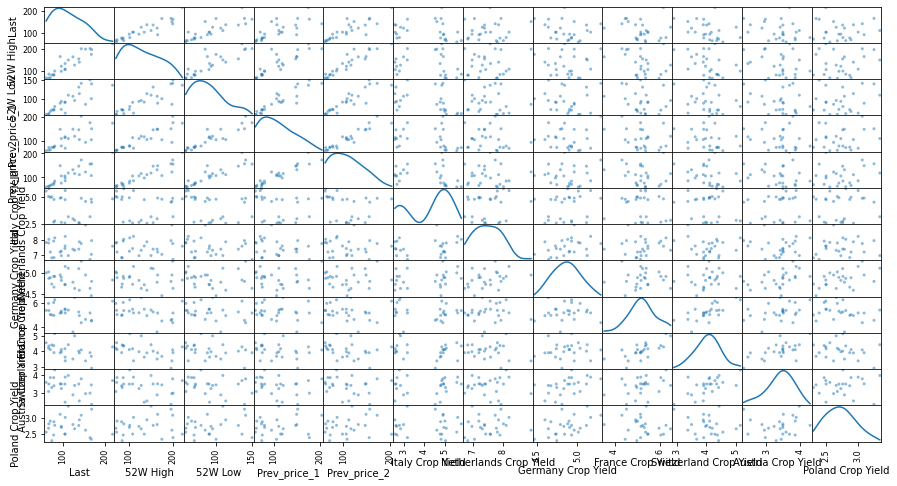

In [89]:
pd.plotting.scatter_matrix(futures.loc[:, "Last":], diagonal="kde")
plt.show()

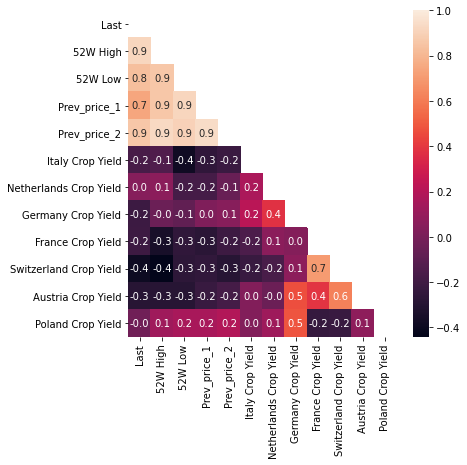

In [90]:
dataset = futures.loc[:, "Last":]
corr = dataset.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(corr, mask=mask, annot=True, fmt= '.1f', ax = ax)


## **Linear Regression**

In [89]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')

In [426]:
cpi = pd.read_csv("D:/Private/Study/Mutivariable analysis project/cpi.csv", parse_dates=["DATE"], date_parser=dateparse)
cpi.set_index("DATE", inplace=True)
cpi = cpi.groupby(by=cpi.index.year).mean()/100

C:\Users\fonma\anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


In [427]:
cpi.head()

CPI
DATE          
1996  0.712258
1997  0.724400
1998  0.733267
1999  0.741867
2000  0.758075

In [428]:
futures['Adjusted prices'] = cpi.CPI*futures.Last

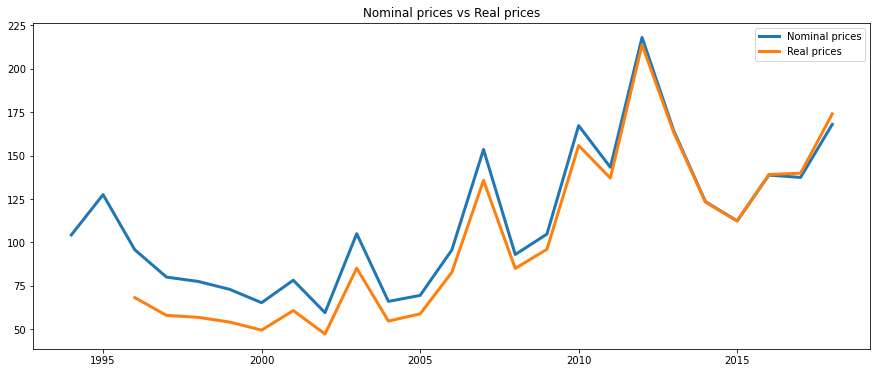

In [429]:
plt.figure(figsize=(15,6))
plt.plot(futures["Last"],  linewidth = 3,label="Nominal prices")
plt.plot(futures["Adjusted prices"],  linewidth = 3, label="Real prices")
plt.title("Nominal prices vs Real prices")
plt.legend()
plt.show()

In [129]:
crops = futures[["austria","france","germany","italy","nether","poland","spain","switz","romania"]]

In [130]:
import numpy as np

In [171]:
crops.head()

austria  france  germany   italy  nether  poland   spain   switz  \
Time                                                                     
1996   5.0069  7.1361   7.2932  3.3170  8.9612  3.4574  3.0016  6.6149   
1997   5.2044  6.6288   7.2902  2.8563  7.7309  3.2064  2.2498  5.9787   
1998   5.0749  7.6063   7.2035  3.5818  7.6956  3.6243  2.8424  6.1811   
1999   5.4348  7.2395   7.5411  3.2434  8.3311  3.5042  2.0987  5.2609   
2000   4.4688  7.1175   7.2826  3.2133  8.3592  3.2268  3.0997  5.9477   

      romania  
Time           
1996   1.7645  
1997   3.0103  
1998   2.5963  
1999   2.7993  
2000   2.2996

In [170]:
crops.drop("Summa",axis=1,inplace=True)

C:\Users\fonma\anaconda3\envs\ml\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [161]:
crops["Summa"] = crops.sum(axis = 1, skipna = True).values 

C:\Users\fonma\anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [162]:
crops.head()

austria  france  germany   italy  nether  poland   spain   switz  \
Time                                                                     
1996   5.0069  7.1361   7.2932  3.3170  8.9612  3.4574  3.0016  6.6149   
1997   5.2044  6.6288   7.2902  2.8563  7.7309  3.2064  2.2498  5.9787   
1998   5.0749  7.6063   7.2035  3.5818  7.6956  3.6243  2.8424  6.1811   
1999   5.4348  7.2395   7.5411  3.2434  8.3311  3.5042  2.0987  5.2609   
2000   4.4688  7.1175   7.2826  3.2133  8.3592  3.2268  3.0997  5.9477   

      romania    Summa  
Time                    
1996   1.7645  46.5528  
1997   3.0103  44.1558  
1998   2.5963  46.4062  
1999   2.7993  45.4530  
2000   2.2996  45.0152

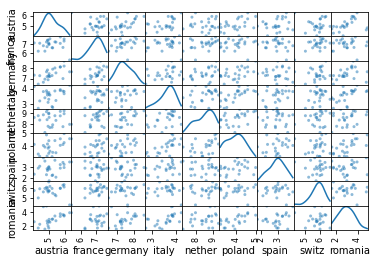

In [134]:
pd.plotting.scatter_matrix(crops, diagonal="kde")
plt.show()

In [163]:
X = crops.Summa

In [164]:
X

Time
1996    46.5528
1997    44.1558
1998    46.4062
1999    45.4530
2000    45.0152
2001    44.8772
2002    44.6376
2003    41.7610
2004    51.3976
2005    46.1661
2006    45.6791
2007    43.7743
2008    50.2245
2009    48.3989
2010    47.8433
2011    48.6823
2012    46.2887
2013    50.1665
2014    52.7848
2015    51.9116
2016    47.7578
2017    50.9077
2018    49.2063
Name: Summa, dtype: float64

In [172]:
X = sm.add_constant(crops)

In [173]:
price = futures.price_adj

In [174]:
price.head()

Time
1996    68.198735
1997    57.952000
1998    56.828167
1999    54.082080
2000    49.464394
Name: price_adj, dtype: float64

In [175]:
model = sm.OLS(price,X)
results = model.fit()

In [176]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_adj   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     5.539
Date:                Thu, 04 Jun 2020   Prob (F-statistic):            0.00299
Time:                        11:45:55   Log-Likelihood:                -102.89
No. Observations:                  23   AIC:                             225.8
Df Residuals:                      13   BIC:                             237.1
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        151.5389    135.594      1.118      0.284    -141.394     444.472
austria      -54.5289     18.766     -2.906      0.012     -95.070     -13.988
france       -24.7553     16.470     -1.503      0.157     -60.337      10.826
germany        3.8976     21.046      0.185      0.856     -41.568      49.364
italy         43.9824     22.744      1.934      0.075      -5.153      93.118
nether        -6.3950     14.792     -0.432      0.673     -38.351      25.561
poland        48.9915     20.010      2.448      0.029       5.763      92.220
spain         17.4826     13.546      1.291      0.219     -11.782      46.747
switz          1.4385     16.469      0.087      0.932     -34.140      37.017
romania        6.4181      9.404      0.683      0.507     -13.897      26.734
==============================================================================
Omnibus:                        2.864   Durbin-Watson:                   1.654
Prob(Omnibus):                  0.239   Jarque-Bera (JB):                1.283
Skew:                           0.105   Prob(JB):                        0.527
Kurtosis:                       1.862   Cond. No.                         391.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [185]:
ypred = results.predict(X)

Time
1996     61.569168
1997     32.591639
1998     75.719652
1999     28.636592
2000     83.511286
2001     45.865660
2002     70.446555
2003     84.721153
2004     75.070655
2005     90.536991
2006     90.917333
2007    141.309176
2008     97.989670
2009    103.158124
2010    135.588375
2011    109.100678
2012    173.953734
2013    134.116277
2014    117.133317
2015    101.886900
2016    160.197127
2017    167.367220
2018    169.339832
dtype: float64


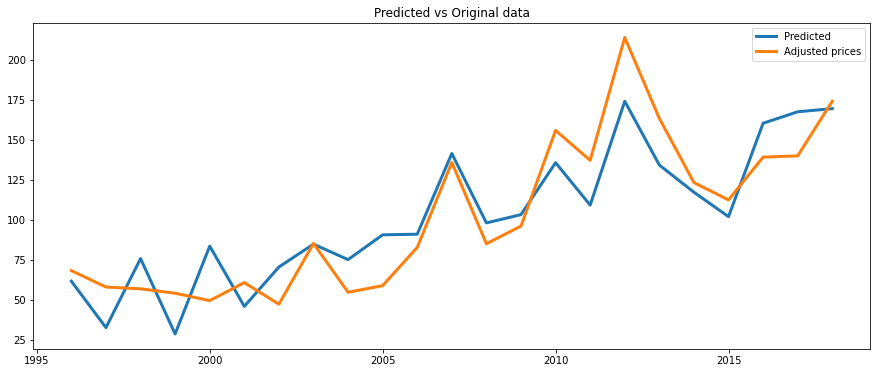

In [199]:
plt.figure(figsize=(15,6))
plt.plot(ypred, label="Predicted", linewidth=3)
plt.plot(futures["Adjusted prices"], label="Adjusted prices",linewidth=3)
plt.title("Predicted vs Original data")
plt.legend()
plt.show()

#  Prediction

In [430]:
futures.head()

Last  52W High  52W Low  Prev_price_1  Prev_price_2   austria  \
Time                                                                    
1994  104.30     108.0    90.25        115.00        106.25  3.493265   
1995  127.50     127.6    95.25        120.75        116.25  3.412907   
1996   95.75     122.5    93.00        111.00        106.50  3.229818   
1997   80.00     101.5    79.15         79.75         85.10  4.312999   
1998   77.50      86.5    69.50         75.00         71.50  3.864276   

        france   germany     italy    nether    poland     switz  \
Time                                                               
1994  5.453859  4.738705  2.590385  7.330458  2.505730  4.174928   
1995  6.445613  4.640989  2.842838  7.091392  2.662809  5.015591   
1996  5.157667  4.831485  2.653522  6.937965  2.734706  3.979670   
1997  6.246721  4.926645  2.788429  8.143925  2.766776  5.155053   
1998  6.020856  4.927290  2.673612  7.938721  2.475780  4.378660   

      Adjusted prices  
Time                   
1994              NaN  
1995              NaN  
1996        68.198735  
1997        57.952000  
1998        56.828167

In [431]:
futures_train = futures.loc['1996':'2011']
futures_test = futures.loc['2012':'2018']

In [432]:
futures_train.head()

Last  52W High  52W Low  Prev_price_1  Prev_price_2   austria  \
Time                                                                   
1996  95.75    122.50    93.00        111.00        106.50  3.229818   
1997  80.00    101.50    79.15         79.75         85.10  4.312999   
1998  77.50     86.50    69.50         75.00         71.50  3.864276   
1999  72.90     84.25    69.90         73.90         70.15  3.292171   
2000  65.25     69.90    58.25         62.10         63.90  3.062573   

        france   germany     italy    nether    poland     switz  \
Time                                                               
1996  5.157667  4.831485  2.653522  6.937965  2.734706  3.979670   
1997  6.246721  4.926645  2.788429  8.143925  2.766776  5.155053   
1998  6.020856  4.927290  2.673612  7.938721  2.475780  4.378660   
1999  4.973956  4.744902  5.015975  6.862390  2.308262  4.420829   
2000  5.944467  5.032428  5.052019  7.806363  2.680410  4.206301   

      Adjusted prices  
Time                   
1996        68.198735  
1997        57.952000  
1998        56.828167  
1999        54.082080  
2000        49.464394

In [495]:
#futures.to_csv("futures table.csv")

In [473]:
scaler = StandardScaler()
X_train = scaler.fit_transform(futures_train.loc[:, (futures_train.columns != 'Adjusted prices') & (futures_train.columns != 'Last')])
X_test = scaler.transform(futures_test.loc[:, (futures_train.columns != 'Adjusted prices') & (futures_train.columns != 'Last')])                              

                          
#X_train = futures_train.loc[:, (futures_train.columns != 'Adjusted prices') & (futures_train.columns != 'Last')]
#X_test = futures_test.loc[:, (futures_train.columns != 'Adjusted prices') & (futures_train.columns != 'Last')]                              

y_train = futures_train['Adjusted prices']
y_test = futures_test['Adjusted prices']
                          
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)


In [474]:
LR = LinearRegression()
LR.fit(X_train, y_train)
predicted_futures = LR.predict(X_test)

In [475]:
futures_test.index

Int64Index([2012, 2013, 2014, 2015, 2016, 2017, 2018], dtype='int64', name='Time')

In [476]:
x = []
for year in futures_test.index:
    x.append(year)

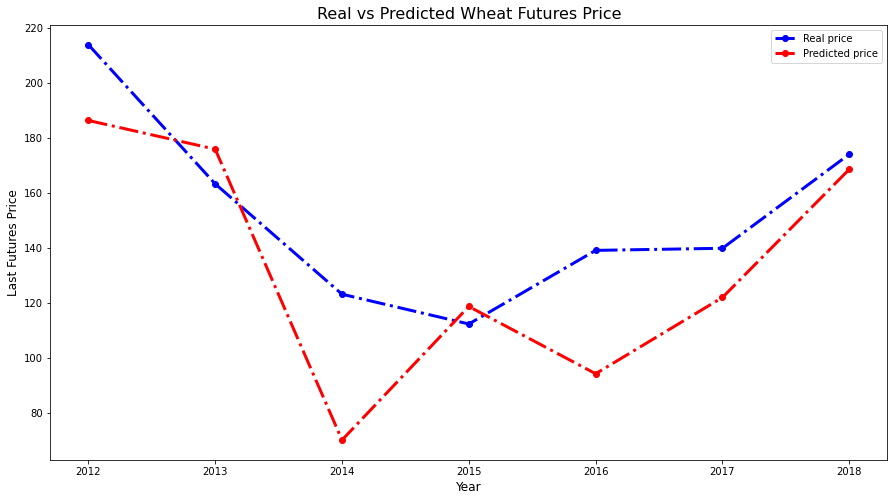

In [477]:
#График реальных и предсказанных значений
plt.plot(x, y_test,'bo-.', linewidth=3,label = u'Real price')
plt.plot(x, predicted_futures,'ro-.',linewidth=3, label = u'Predicted price')
plt.title('Real vs Predicted Wheat Futures Price',fontsize=16)
plt.legend()
plt.xlabel(u'Year',fontsize=12)
plt.ylabel(u'Last Futures Price',fontsize=12)
plt.show()

In [478]:
def residuals_plots(y_test, prediction, color = 'blue'):
    prediction = np.ravel(prediction)
    y_test = np.ravel(y_test)
    # Рассчитываем ошибки
    errors = prediction - y_test
    errors = np.ravel(errors)
    
    plot_data = pd.DataFrame({'Errors': errors,
                              'Prediction': prediction})
    
    with sns.axes_style("ticks"):
        g = (sns.jointplot('Prediction', 'Errors',  height = 7, alpha = 0.6,
                           data=plot_data, color= color).plot_joint(sns.kdeplot, zorder=0, n_levels=6))
        g.ax_joint.plot([min(prediction)-0.1, max(prediction)+0.1],[0, 0], linewidth = 1, linestyle='--', color= color)
        g.ax_marg_y.axhline(y = 0, linewidth = 1, linestyle='--', color= color)
        plt.xlabel('Predicted value', fontsize = 15)
        plt.ylabel('Errors, $', fontsize = 15)
        plt.show()
        
        g = (sns.jointplot('Prediction', 'Errors', kind="kde", data = plot_data, space=0, height = 7,
                      color = color, alpha = 0.2))
        g.set_axis_labels('Predicted value', 'Errors, $', fontsize = 15)
        g.ax_joint.plot([min(prediction)-0.1, max(prediction)+0.1],[0, 0], linewidth = 1, linestyle='--', color= color)
        g.ax_marg_y.axhline(y = 0, linewidth = 1, linestyle='--', color= color)
        plt.show()

In [479]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

Mean absolute error in the test sample - 23.932022716043036
Median absolute error in the test sample - 17.855820801205596
Root mean square error in the test sample - 29.555734487402223
Mean absolute percentage error in the test sample - 16.764170345211795
Coefficient of determination in the training sample - 0.9894262551050295


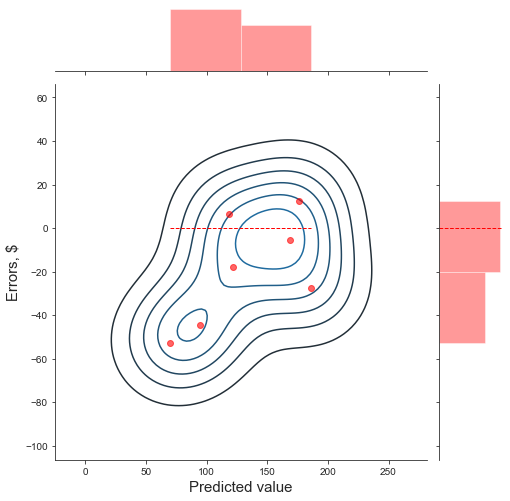

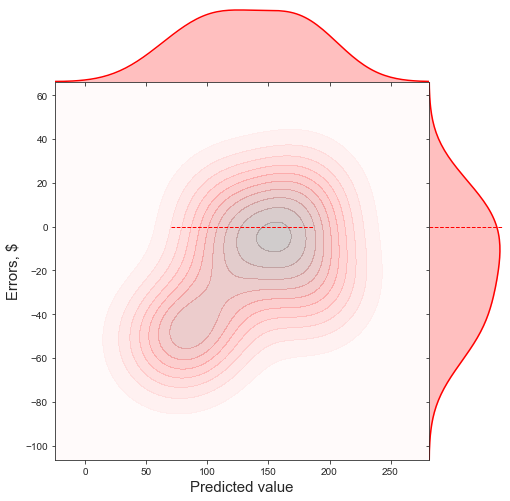

In [480]:
rcParams['figure.figsize'] = 15, 8
print_metrics(y_test, predicted_futures, LR, r2 = True)
residuals_plots(y_test, predicted_futures, color = 'red')

In [481]:
clf = linear_model.Lasso(alpha=0.1)
clf.fit(X_train, y_train)
print(clf.coef_)

[ 27.95869434  27.53057339 -17.26885393  -6.18295722   7.33047535
   5.86924335  -2.17246722   9.50244579   0.          -4.29832201
 -10.60286363]


In [482]:
model_aic = LassoLarsIC(criterion='aic')
model_aic.fit(X_train, y_train)
alpha_aic_ = model_aic.coef_
alpha_aic_

array([18.92969375,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ])

In [483]:
y_pred_lasso = clf.predict(X_test)
y_pred_lasso_aic = model_aic.predict(X_test)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
mae_lasso_aic = mean_absolute_error(y_test, y_pred_lasso_aic)
print('Mean absolute error with lasso = ', mae_lasso)
print('Mean squared error with lasso = ', mse_lasso)
print('Mean absolute error with aic lasso = ', mae_lasso_aic)


Mean absolute error with lasso =  23.092214599905738
Mean squared error with lasso =  751.8750015485119
Mean absolute error with aic lasso =  46.174352041728454


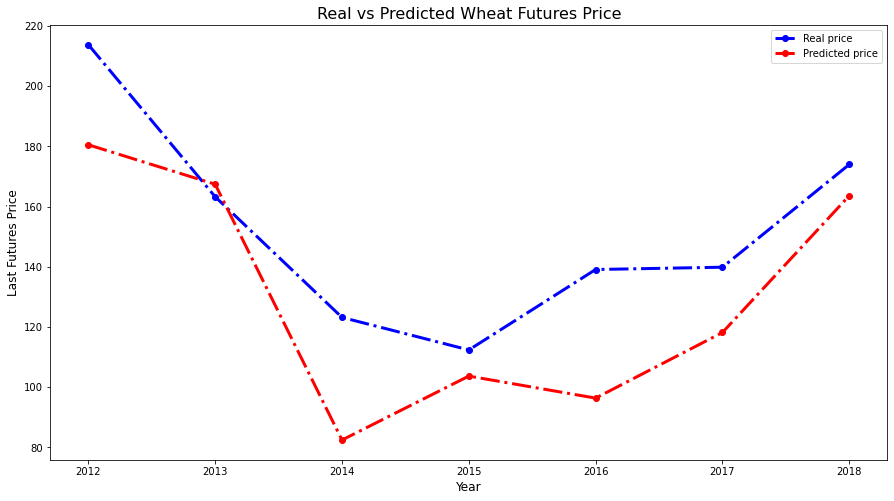

In [484]:
plt.plot(x, y_test,'bo-.', linewidth=3,label = u'Real price')
plt.plot(x, y_pred_lasso,'ro-.',linewidth=3, label = u'Predicted price')
plt.title('Real vs Predicted Wheat Futures Price',fontsize=16)
plt.legend()
plt.xlabel(u'Year',fontsize=12)
plt.ylabel(u'Last Futures Price',fontsize=12)
plt.show()

Mean absolute error in the test sample - 9.227253628435607
Median absolute error in the test sample - 8.683994707003023
Root mean square error in the test sample - 11.216938855099926
Mean absolute percentage error in the test sample - 6.605934920537375
Coefficient of determination in the training sample - 0.9872798547086904


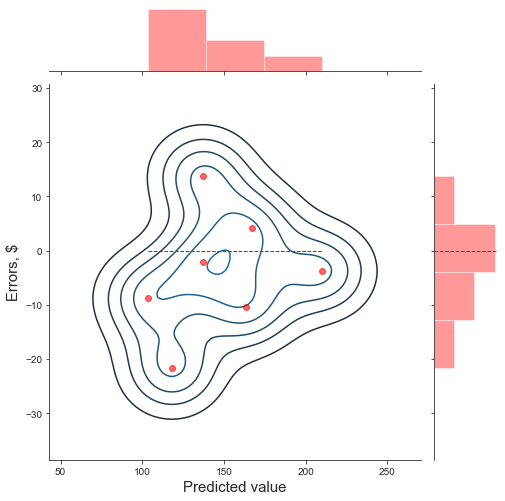

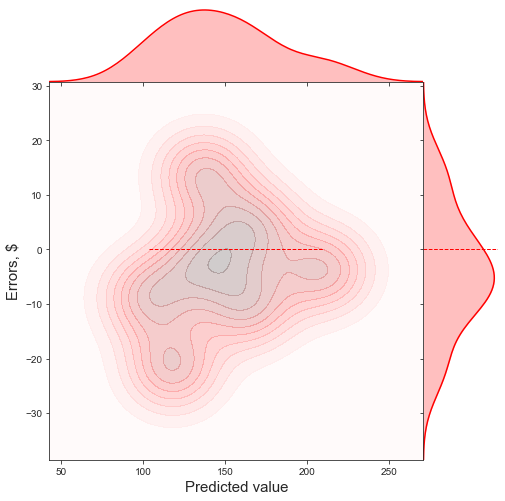

In [505]:
rcParams['figure.figsize'] = 15, 8
print_metrics(y_test, y_pred_lasso, clf, r2 = True)
residuals_plots(y_test, y_pred_lasso, color = 'red')

# ARIMA

In [490]:
!pip install pyramid-arima

  Running setup.py clean for pyramid-arima
Failed to build pyramid-arima
    Running setup.py install for pyramid-arima: started
    Running setup.py install for pyramid-arima: finished with status 'error'


  ERROR: Command errored out with exit status 1:
   command: 'c:\users\fonma\anaconda3\envs\ml\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\fonma\\AppData\\Local\\Temp\\pip-install-kbms0fyw\\pyramid-arima\\setup.py'"'"'; __file__='"'"'C:\\Users\\fonma\\AppData\\Local\\Temp\\pip-install-kbms0fyw\\pyramid-arima\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\fonma\AppData\Local\Temp\pip-wheel-pu8vl_8r'
       cwd: C:\Users\fonma\AppData\Local\Temp\pip-install-kbms0fyw\pyramid-arima\
  Complete output (171 lines):
  Partial import of pyramid during the build process.
  Requirements: ['Cython>=0.23\nnumpy>=1.10\nscipy>=0.9\nscikit-learn>=0.17\npandas>=0.19\nstatsmodels>=0.9.0\n']
  Adding extra setuptools args
  blas_opt_info:
  blas_mkl_info:
  No module named 'numpy.distutils._msvccompiler' in numpy.

      NOT AVAILABLE
    
    c:\users\fonma\anaconda3\envs\ml\lib\site-packages\numpy\distutils\system_info.py:1896: UserWarning:
        Blas (http://www.netlib.org/blas/) sources not found.
        Directories to search for the sources can be specified in the
        numpy/distutils/site.cfg file (section [blas_src]) or by setting
        the BLAS_SRC environment variable.
      if self._calc_info(blas):
      NOT AVAILABLE
    
    running install
    running build
    running config_cc
    unifing config_cc, config, build_clib, build_ext, build commands --compiler options
    running config_fc
    unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
    running build_src
    build_src
    building extension "pyramid.__check_build._check_build" sources
    building extension "pyramid.arima._arima" sources
    build_src: building npy-pkg config files
    running build_py
    creating build
    creating build\lib.win-amd64-3.7
    creating build\lib.win

In [494]:
from pyramid.arima import auto_arima

ModuleNotFoundError: No module named 'pyramid.arima'

# **Random Forest**

In [448]:
#Random Forest Model
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(X_train, y_train)
predicted_futures_rf = forest_reg.predict(X_test)

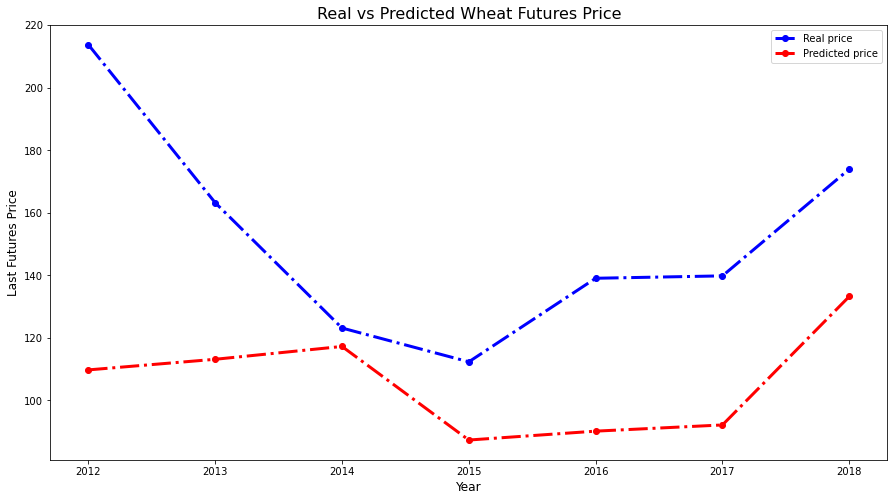

In [449]:
plt.plot(x, y_test,'bo-.', linewidth=3,label = u'Real price')
plt.plot(x, predicted_futures_rf,'ro-.',linewidth=3, label = u'Predicted price')
plt.title('Real vs Predicted Wheat Futures Price',fontsize=16)
plt.legend()
plt.xlabel(u'Year',fontsize=12)
plt.ylabel(u'Last Futures Price',fontsize=12)
plt.show()

Mean absolute error in the test sample - 46.03707648630955
Median absolute error in the test sample - 47.67138676250009
Root mean square error in the test sample - 53.85746860565083
Mean absolute percentage error in the test sample - 28.43157059243034
Coefficient of determination in the training sample - 0.9549689278224874


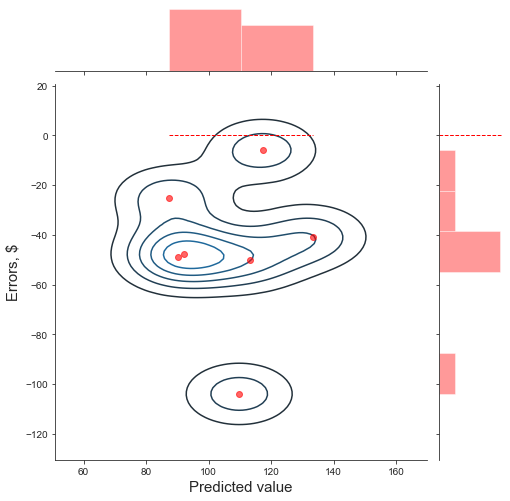

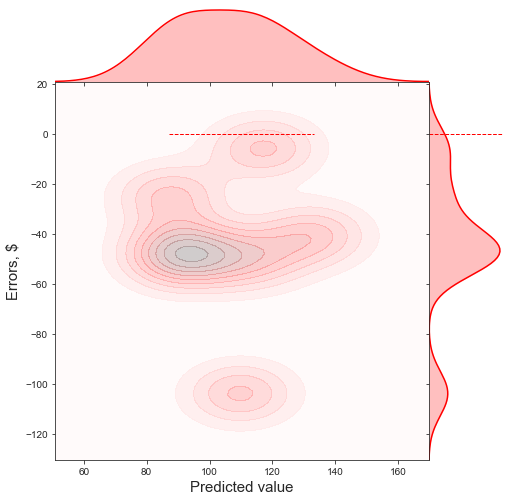

In [450]:
rcParams['figure.figsize'] = 15, 8
print_metrics(y_test, predicted_futures_rf, forest_reg, r2 = True)
residuals_plots(y_test, predicted_futures_rf, color = 'red')

## **Gradient Boosting**

In [451]:
#Gradient boosting model
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor
model = ensemble.GradientBoostingRegressor()
model.fit(X_train, y_train)
predicted_futures_gb = model.predict(X_test)

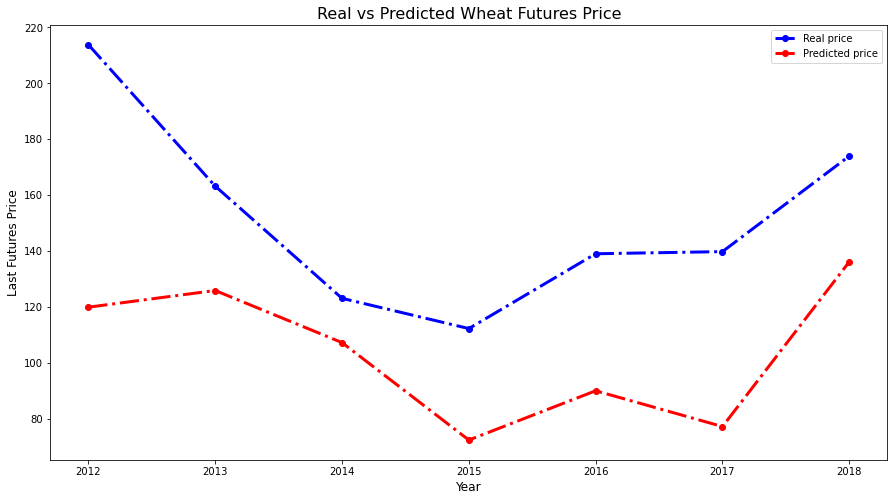

In [452]:
plt.plot(x, y_test,'bo-.', linewidth=3,label = u'Real price')
plt.plot(x, predicted_futures_gb,'ro-.',linewidth=3, label = u'Predicted price')
plt.title('Real vs Predicted Wheat Futures Price',fontsize=16)
plt.legend()
plt.xlabel(u'Year',fontsize=12)
plt.ylabel(u'Last Futures Price',fontsize=12)
plt.show()

In [453]:
feature_labels = np.array(['Italy Crop Yield','Netherlands Crop Yield', 
                           'Germany Crop Yield','Switzerland Crop Yield', 'Austria Crop Yield', 'Poland Crop Yield',
                           'Prev_price_1','Prev_price_2'])
importance = model.feature_importances_
feature_indexes_by_importance = importance.argsort()
for index in feature_indexes_by_importance:
    print('{}-{:.2f}%'.format(feature_labels[index], (importance[index] *100.0)))

Netherlands Crop Yield-0.05%
Austria Crop Yield-0.13%
Prev_price_1-0.15%


IndexError: index 9 is out of bounds for axis 0 with size 8

Mean absolute error in the test sample - 47.99164830087508
Median absolute error in the test sample - 39.82214740469931
Root mean square error in the test sample - 53.11806131698312
Mean absolute percentage error in the test sample - 30.944052237165597
Coefficient of determination in the training sample - 0.9549689278224874


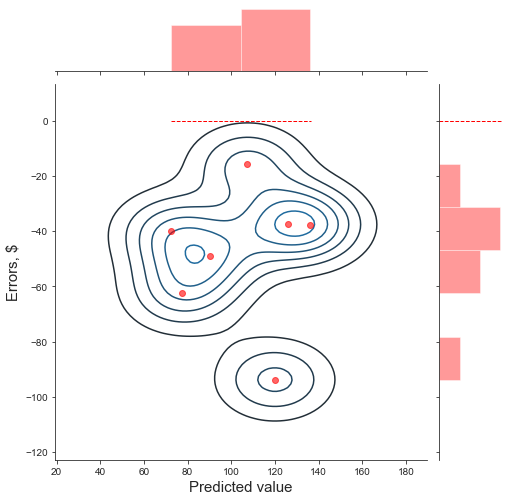

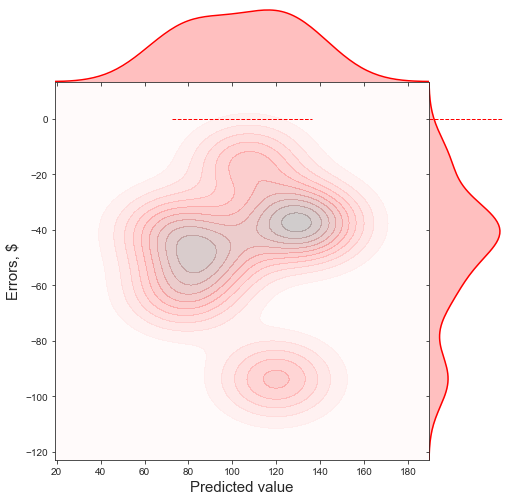

In [454]:
rcParams['figure.figsize'] = 15, 8
print_metrics(y_test, predicted_futures_gb, forest_reg, r2 = True)
residuals_plots(y_test, predicted_futures_gb, color = 'red')